In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import torch.nn.functional as F
from types import SimpleNamespace
import torch.optim as optim

from layers.Embed import DataEmbedding
from layers.Conv_Blocks import Inception_Block_V1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

configs = SimpleNamespace()
configs.seq_len = 100  
configs.pred_len = 1         
configs.label_len = 0
configs.top_k = 2
configs.d_model = 96  
configs.d_ff = 192  
configs.num_kernels = 3
configs.e_layers = 3
configs.enc_in = 2          
configs.c_out = 6           
configs.embed = 'fixed'
configs.freq = 'h'
configs.dropout = 0.15
configs.task_name = 'short_term_forecast'
configs.num_class = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda


# TimesNet

In [16]:
def FFT_for_Period(x, k=2):
    x = x.float()   
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = [max(1, x.shape[1] // int(t)) for t in top_list]
    return period, abs(xf).mean(-1)[:, top_list]

class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(configs.d_model, configs.d_ff,
                               num_kernels=configs.num_kernels),
            nn.GELU(),
            Inception_Block_V1(configs.d_ff, configs.d_model,
                               num_kernels=configs.num_kernels)
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x
            # reshape
            out = out.reshape(B, length // period, period, N).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res

# Graph Residual Block

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphResidualBlock(nn.Module):
    def __init__(self, num_nodes, hidden_dim=32):
        super().__init__()
        self.num_nodes = num_nodes

        self.A_param = nn.Parameter(torch.randn(num_nodes, num_nodes))

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.dim() == 3:  
            x = x.squeeze(1)  

        A = torch.softmax(self.A_param, dim=-1)   
        h = x.unsqueeze(-1)          
        h = self.fc1(h)              
        h = torch.matmul(A, h)       
        h = F.relu(h)
        h = self.fc2(h).squeeze(-1)  

        return x + h   


## TFT

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRN(nn.Module):
    """Gated Residual Network (Simplified version)"""
    def __init__(self, input_dim, hidden_dim, output_dim=None, dropout=0.3):
        super().__init__()
        output_dim = output_dim or input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.gate = nn.Linear(output_dim, output_dim)
        self.norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = F.gelu(self.fc1(x))
        x = self.dropout(self.fc2(x))
        gate = torch.sigmoid(self.gate(x))
        x = gate * x + (1 - gate) * residual
        return self.norm(x)

In [19]:
class PositionalEncoding(nn.Module):
    """Standard Transformer Position Encoding"""
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


In [20]:
class CompactTFT(nn.Module):
    def __init__(self, enc_in, d_model=64, n_heads=4, n_layers=2, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Linear(enc_in, d_model)
        self.pos_encoding = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=d_model*2, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.static_fuse = GRN(d_model, d_model*2, d_model, dropout=dropout)

        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, static_emb=None):
        x = self.input_proj(x)
        x = self.pos_encoding(x)
        x = self.encoder(x)

        if static_emb is not None:
            s = static_emb.unsqueeze(1).repeat(1, x.size(1), 1)
            x = self.static_fuse(x + s)

        return self.norm(x)

In [21]:
class Model(nn.Module):
    def __init__(self, configs, static_dim=7):
        super(Model, self).__init__()
        self.configs = configs
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.layer = configs.e_layers

        self.tft = CompactTFT(
            enc_in=configs.enc_in, d_model=configs.d_model, n_heads=4, n_layers=3, dropout=configs.dropout
        )

        self.model = nn.ModuleList([TimesBlock(configs) for _ in range(configs.e_layers)])
        self.layer_norm = nn.LayerNorm(configs.d_model)

        self.static_proj = nn.Linear(static_dim, configs.d_model)

        self.projection = nn.Linear(configs.d_model, configs.c_out)
        self.graph_residual = GraphResidualBlock(num_nodes=configs.c_out, hidden_dim=32)

        self.predict_linear = nn.Linear(self.seq_len, self.pred_len + self.seq_len)

    def _add_static_to_enc(self, enc_out, x_static):
        if x_static is None:
            return enc_out
        static_emb = self.static_proj(x_static)                    # [B, d_model]
        static_emb = static_emb.unsqueeze(1).repeat(1, enc_out.size(1), 1)  # [B, T, d_model]
        return enc_out + static_emb

    def forecast(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, x_static=None):
        enc_out = self.tft(x_enc, static_emb=x_static)  
        enc_out = self.predict_linear(enc_out.permute(0, 2, 1)).permute(0, 2, 1)  

        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        dec_out = self.projection(enc_out)   
        
        dec_out = self.graph_residual(dec_out[:, -self.pred_len:, :])  
        dec_out = dec_out.unsqueeze(1)  

        return dec_out

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None, x_static=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec, x_static=x_static)
        return dec_out.squeeze(1)  

In [22]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)  
data_dir = os.path.join(parent_dir, "TestSet")   
print(f"Data directory: {data_dir}")

X_seq_test = np.load(os.path.join(data_dir, "X_seq_test.npy"))
X_static_test = np.load(os.path.join(data_dir, "X_static_test.npy"))
Y_test = np.load(os.path.join(data_dir, "Y_test.npy"))

print("test set:", X_seq_test.shape, X_static_test.shape, Y_test.shape)

def load_minmax_scaler(file_path):
    data = np.load(file_path)
    return data['min_val'], data['max_val']

X_seq_scaler_file_path = os.path.join(current_dir, r"Scaler\X_seq_minmax_scaler.npz")
X_static_scaler_file_path = os.path.join(current_dir, r"Scaler\X_static_minmax_scaler.npz")
Y_scaler_file_path = os.path.join(current_dir, r"Scaler\Y_static_minmax_scaler.npz")

X_seq_min, X_seq_max = load_minmax_scaler(X_seq_scaler_file_path)
X_static_min, X_static_max = load_minmax_scaler(X_static_scaler_file_path)
Y_min, Y_max = load_minmax_scaler(Y_scaler_file_path)

print("✅ Min-Max normalizer has been loaded")

def apply_minmax(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

case_dir = os.path.join(data_dir, "test_cases")
test_data_per_case = {}

if not os.path.isdir(case_dir):
    raise FileNotFoundError(f"Test condition catalog not found: {case_dir}")

case_ids = []
for fn in os.listdir(case_dir):
    if fn.startswith("X_seq_case") and fn.endswith(".npy"):
        cid = int(fn.replace("X_seq_case", "").replace(".npy", ""))
        case_ids.append(cid)
case_ids = sorted(case_ids)

for cid in case_ids:
    X_seq_case = np.load(os.path.join(case_dir, f"X_seq_case{cid}.npy"))
    X_static_case = np.load(os.path.join(case_dir, f"X_static_case{cid}.npy"))
    Y_case = np.load(os.path.join(case_dir, f"Y_case{cid}.npy"))
    test_data_per_case[cid] = (X_seq_case, X_static_case, Y_case)

print(f"✅ test_data_per_case : {len(test_data_per_case)} test cases -> {list(test_data_per_case.keys())}")

# ========== Min-Max Normalization ==========
# X_seq_test：flatten → apply → reshape
X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
X_seq_test = apply_minmax(X_seq_test_flat, X_seq_min, X_seq_max).reshape(-1, configs.seq_len, X_seq_test.shape[-1])
X_static_test = apply_minmax(X_static_test, X_static_min, X_static_max)
Y_test = apply_minmax(Y_test, Y_min, Y_max)

# ============================
# Normalized test_data_per_case_norm (based on training set min/max)
# ============================
test_data_per_case_norm = {}
for cid, (X_seq_case, X_static_case, Y_case) in test_data_per_case.items():
    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = apply_minmax(X_seq_flat, X_seq_min, X_seq_max).reshape(X_seq_case.shape)
    X_static_case_norm = apply_minmax(X_static_case, X_static_min, X_static_max)
    Y_case_norm = apply_minmax(Y_case, Y_min, Y_max)
    test_data_per_case_norm[cid] = (X_seq_case_norm, X_static_case_norm, Y_case_norm)
print("✅ test_data_per_case_norm established")


X_seq_test_t = torch.tensor(X_seq_test, dtype=torch.float32)
X_static_test_t = torch.tensor(X_static_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)

test_dataset  = TensorDataset(X_seq_test_t, X_static_test_t, Y_test_t)
batch_size = 512
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\TestSet
test set: (13006, 100, 2) (13006, 1) (13006, 6)
✅ Min-Max normalizer has been loaded
✅ test_data_per_case : 9 test cases -> [3, 6, 13, 15, 22, 24, 34, 38, 42]
✅ test_data_per_case_norm established


In [23]:
Y_min_t = torch.tensor(Y_min, dtype=torch.float32, device=device)   
Y_max_t = torch.tensor(Y_max, dtype=torch.float32, device=device)    
Y_range_t = (Y_max_t - Y_min_t).clamp_min(1e-8)                    

# Model Evaluation

In [24]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Best_PINN_CTFT_TimesNet_GR.pth")   
print(f"Data directory: {data_dir}")

best_model = torch.load(data_dir, weights_only = False)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\1_CTFT_TimesNet_GR\Best_PINN_CTFT_TimesNet_GR.pth


In [25]:
print(best_model)

Model(
  (tft): CompactTFT(
    (input_proj): Linear(in_features=2, out_features=96, bias=True)
    (pos_encoding): PositionalEncoding()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
          )
          (linear1): Linear(in_features=96, out_features=192, bias=True)
          (dropout): Dropout(p=0.15, inplace=False)
          (linear2): Linear(in_features=192, out_features=96, bias=True)
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.15, inplace=False)
          (dropout2): Dropout(p=0.15, inplace=False)
        )
      )
    )
    (static_fuse): GRN(
      (fc1): Linear(in_features=96, out_features=192, bias=True)
      (fc2): Linear(in_features=192, out

In [26]:
import numpy as np

def median_absolute_error(y_true, y_pred):
    """
    Median Absolute Error (MdAE)
    """
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

def iqr_based_mae(y_true, y_pred):
    
    errors = np.abs(y_true - y_pred).flatten()  
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan   
    return np.mean(filtered_errors)


def NSE_global(y_true, y_pred, eps=1e-12): 
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - num / (den + eps)


def R2_global(y_true, y_pred, eps=1e-12): 
    return NSE_global(y_true, y_pred, eps=eps)


def NSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


def hit_rate(y_true, y_pred, delta): 
    relative_errors = np.abs((y_pred - y_true) / y_true) * 100   
    hits = relative_errors <= delta
    return np.mean(hits) * 100  

def KGE(y_true, y_pred):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / np.mean(y_true)
    gamma = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge


def willmott_d(y_true, y_pred):
    """Willmott’s Index of Agreement"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_mean = np.mean(y_true)
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((np.abs(y_pred - y_mean) + np.abs(y_true - y_mean))**2)
    if denominator == 0:
        return np.nan
    return 1 - numerator / denominator


def willmott_index_modified(observed, predicted):
    """
    Willmott's Modified Index of Agreement (Willmott et al., 2012)
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed)))
    
    if denominator == 0:
        return 1.0 if numerator == 0 else 0.0
    
    d = 1 - (numerator / denominator)
    return np.clip(d, 0, 1)

max_delta=5
deltas = np.arange(0.25, max_delta+0.25, 0.25)  # δ = 1% ~ max_delta%
print(deltas)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = R2_global(y_true, y_pred) #r2_score(y_true, y_pred)
    nse = NSE_global(y_true, y_pred)  #NSE(y_true, y_pred)
    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    return {
        'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MAE': mae,
        'R2': r2, 'NSE': nse, 'KGE': kge, 'd': d_index,
        'HitRate': hr, 'MdAE': mdae, 'IQR-based MAE': iqr_mae, 'MaxError': max_err
    }


[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [27]:
best_model = best_model.to(device)
best_model.eval() 

def predict_norm(model, X_seq_norm, X_static_norm, device):
    model.eval()
    X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
    X_static_t = torch.tensor(X_static_norm, dtype=torch.float32, device=device)

    with torch.no_grad():
        B = X_seq_t.shape[0]
        seq_len = X_seq_t.shape[1]
        pred_len = 1

        x_mark_enc = torch.zeros(B, seq_len, 5, device=device)
        x_dec = torch.zeros(B, pred_len, X_seq_t.shape[-1], device=device)
        x_mark_dec = torch.zeros(B, pred_len, 5, device=device)

        out = model(X_seq_t, x_mark_enc, x_dec, x_mark_dec, x_static=X_static_t)  # [B,1,6] or [B, pred_len, 6]
        out = out.squeeze(1)  
        return out.detach().cpu().numpy()

def denorm_y(y_norm, Y_min, Y_max):
    return y_norm * (Y_max - Y_min) + Y_min
 
print("\n===================== Test condition indicators (output first) =====================")

case_metrics = {}   

for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, X_static_case_norm, Y_case_norm = test_data_per_case_norm[cid]
 
    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, X_static_case_norm, device)
 
    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)
 
    metrics_case = evaluate_metrics(y_true_case_real, y_pred_case_real)
    case_metrics[cid] = metrics_case
 
    print(f"\n--- Case {cid} ---")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else: 
            hr_str = ", ".join([f"{h:.2f}" for h in v])
            print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")
 
print("\n===================== The metrics for the entire test set (final output) =====================")
 
y_pred_total_norm = predict_norm(best_model, X_seq_test, X_static_test, device)
 
y_pred_total_real = denorm_y(y_pred_total_norm, Y_min, Y_max)
y_true_total_real = denorm_y(Y_test, Y_min, Y_max)

metrics_total = evaluate_metrics(y_true_total_real, y_pred_total_real)

print("\n--- Full test set Overall ---")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        hr_str = ", ".join([f"{h:.2f}" for h in v])
        print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")



===================== Test condition indicators (output first) =====================

--- Case 3 ---
MSE: 0.005010
RMSE: 0.070784
MAPE: 0.004925
MAE: 0.057106
R2: 0.864190
NSE: 0.864190
KGE: 0.906955
d: 0.815449
HitRate(δ=1~5%): [30.87, 58.90, 77.45, 89.07, 95.43, 99.12, 99.88, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.047662
IQR-based MAE: 0.049489
MaxError: 0.202498

--- Case 6 ---
MSE: 0.004921
RMSE: 0.070148
MAPE: 0.003622
MAE: 0.052017
R2: 0.825138
NSE: 0.825138
KGE: 0.845608
d: 0.816731
HitRate(δ=1~5%): [50.57, 75.12, 82.53, 93.10, 99.61, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.035130
IQR-based MAE: 0.037974
MaxError: 0.184608

--- Case 13 ---
MSE: 0.007859
RMSE: 0.088653
MAPE: 0.006618
MAE: 0.074625
R2: 0.833411
NSE: 0.833411
KGE: 0.925137
d: 0.796463
HitRate(δ=1~5%): [18.48, 40.62, 60.50, 80.44, 90.29, 95.92, 98.10, 99.51

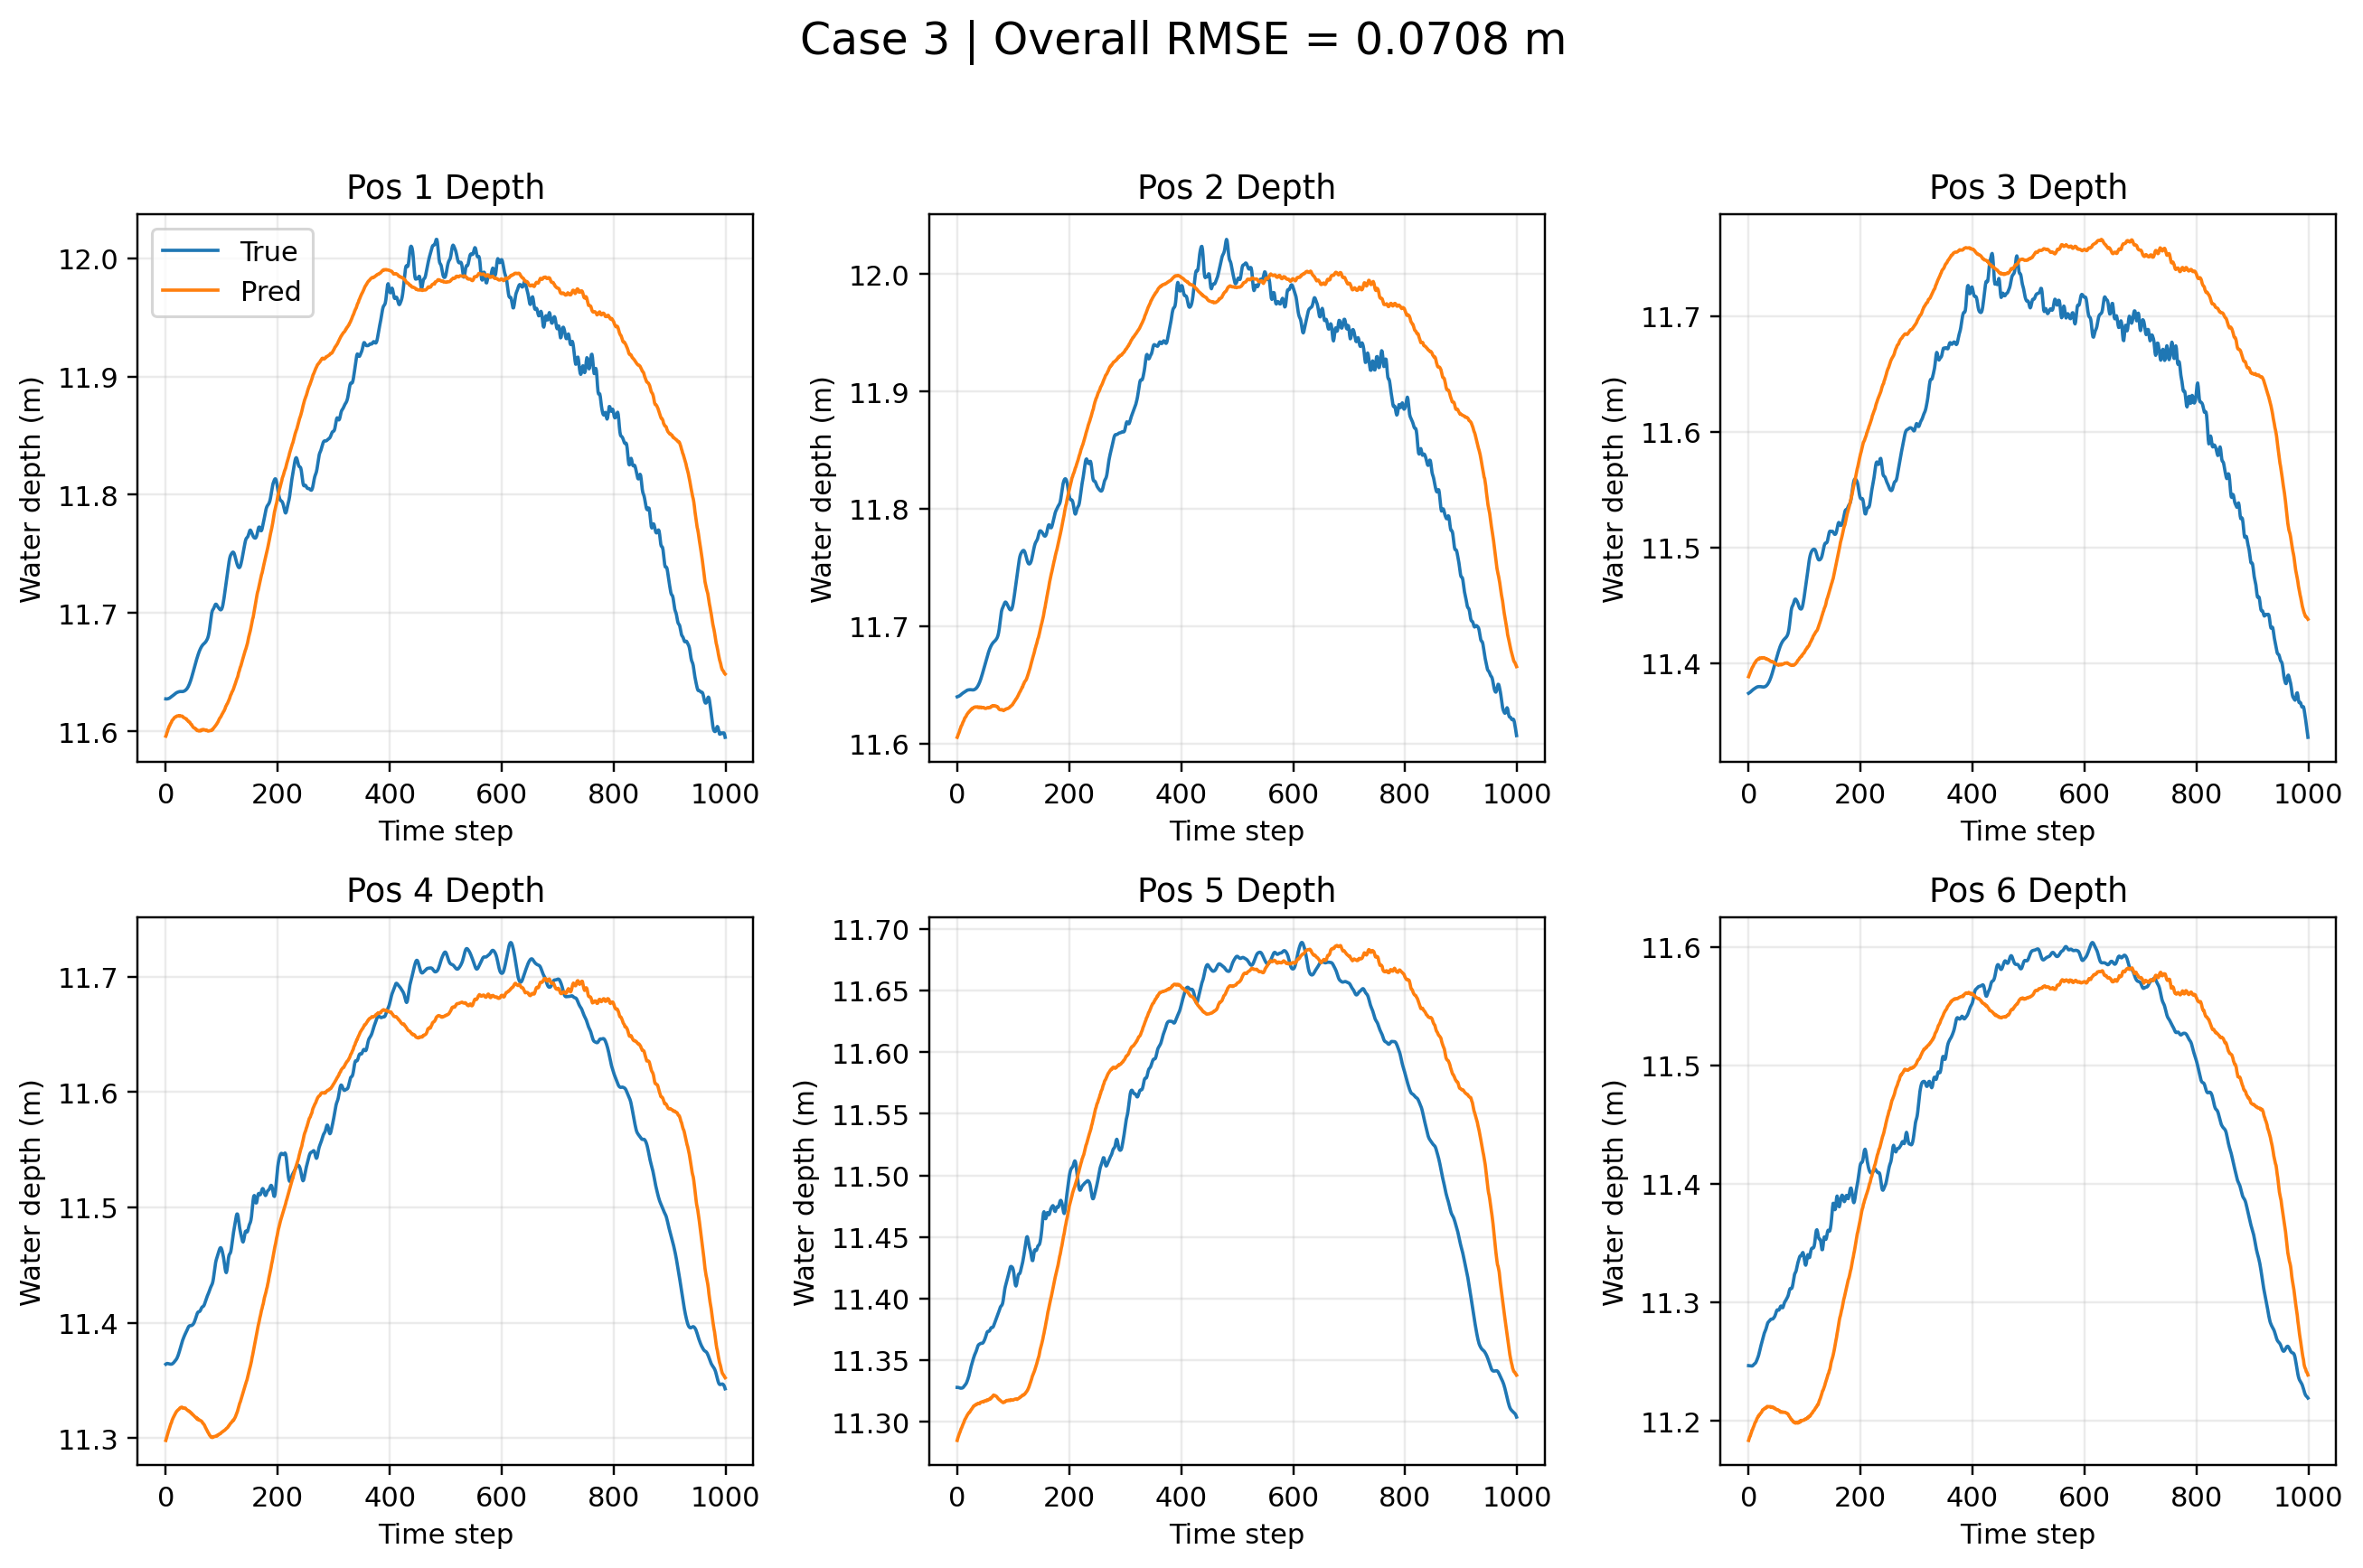

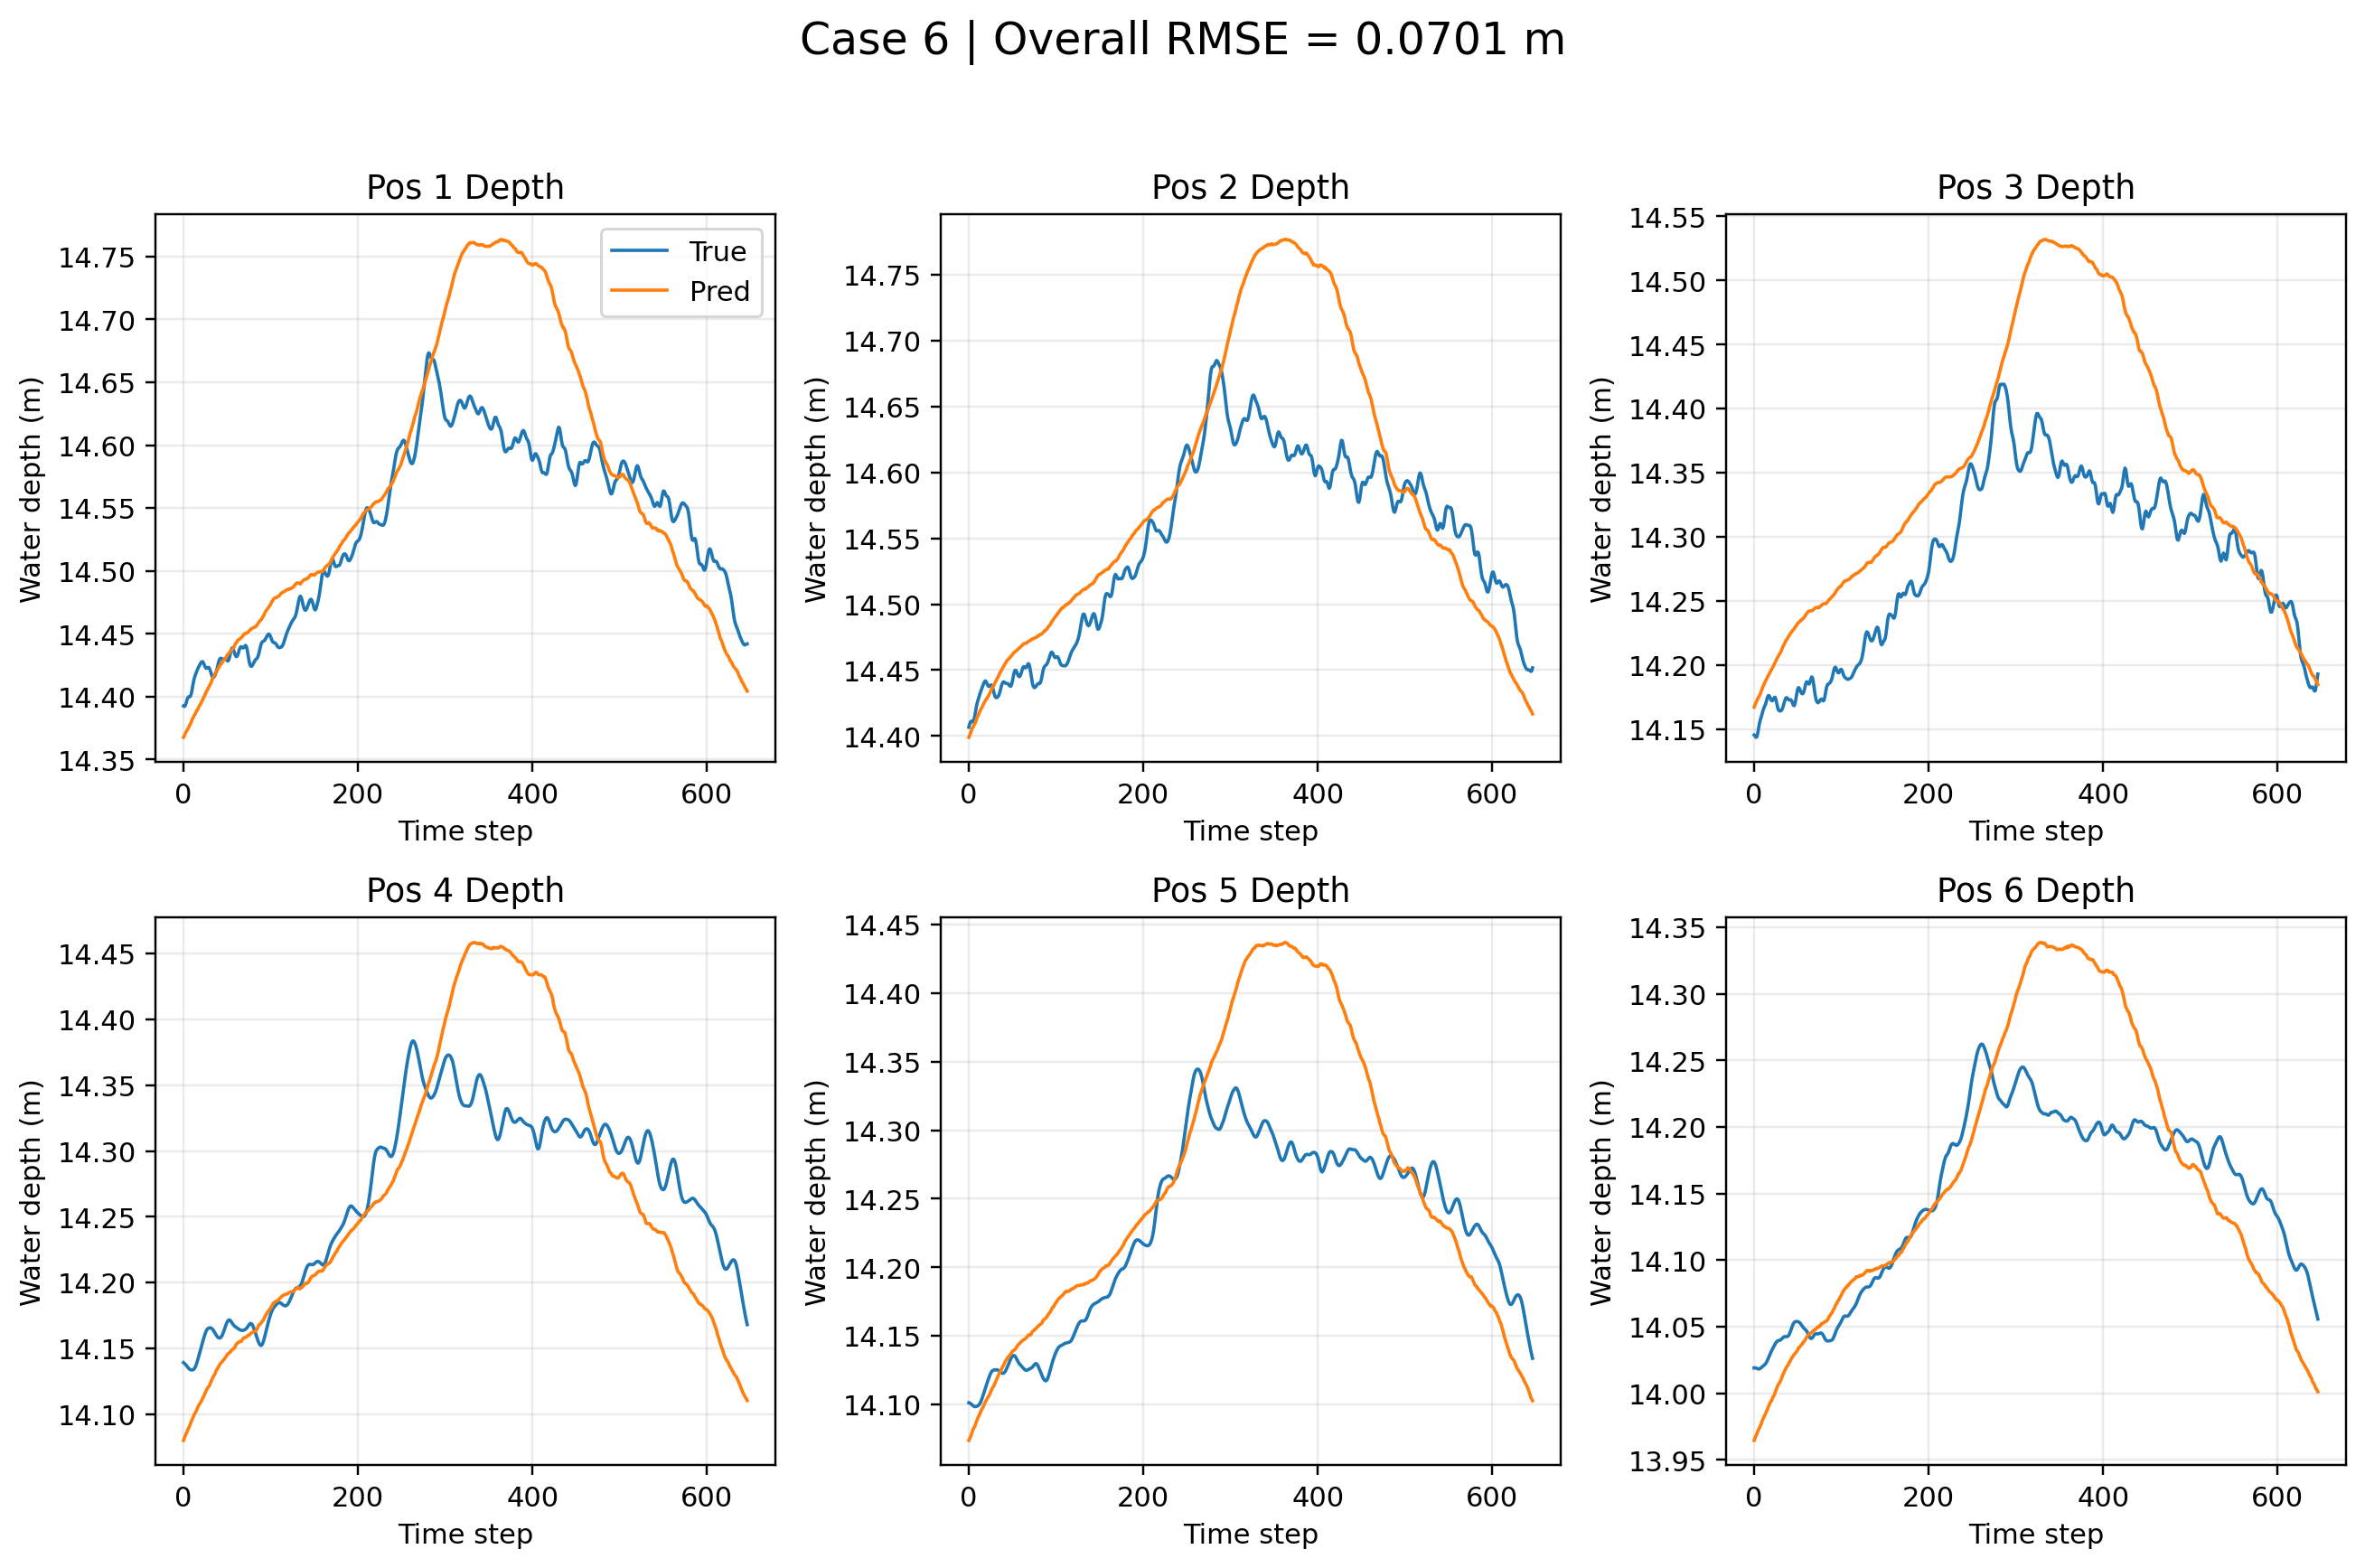

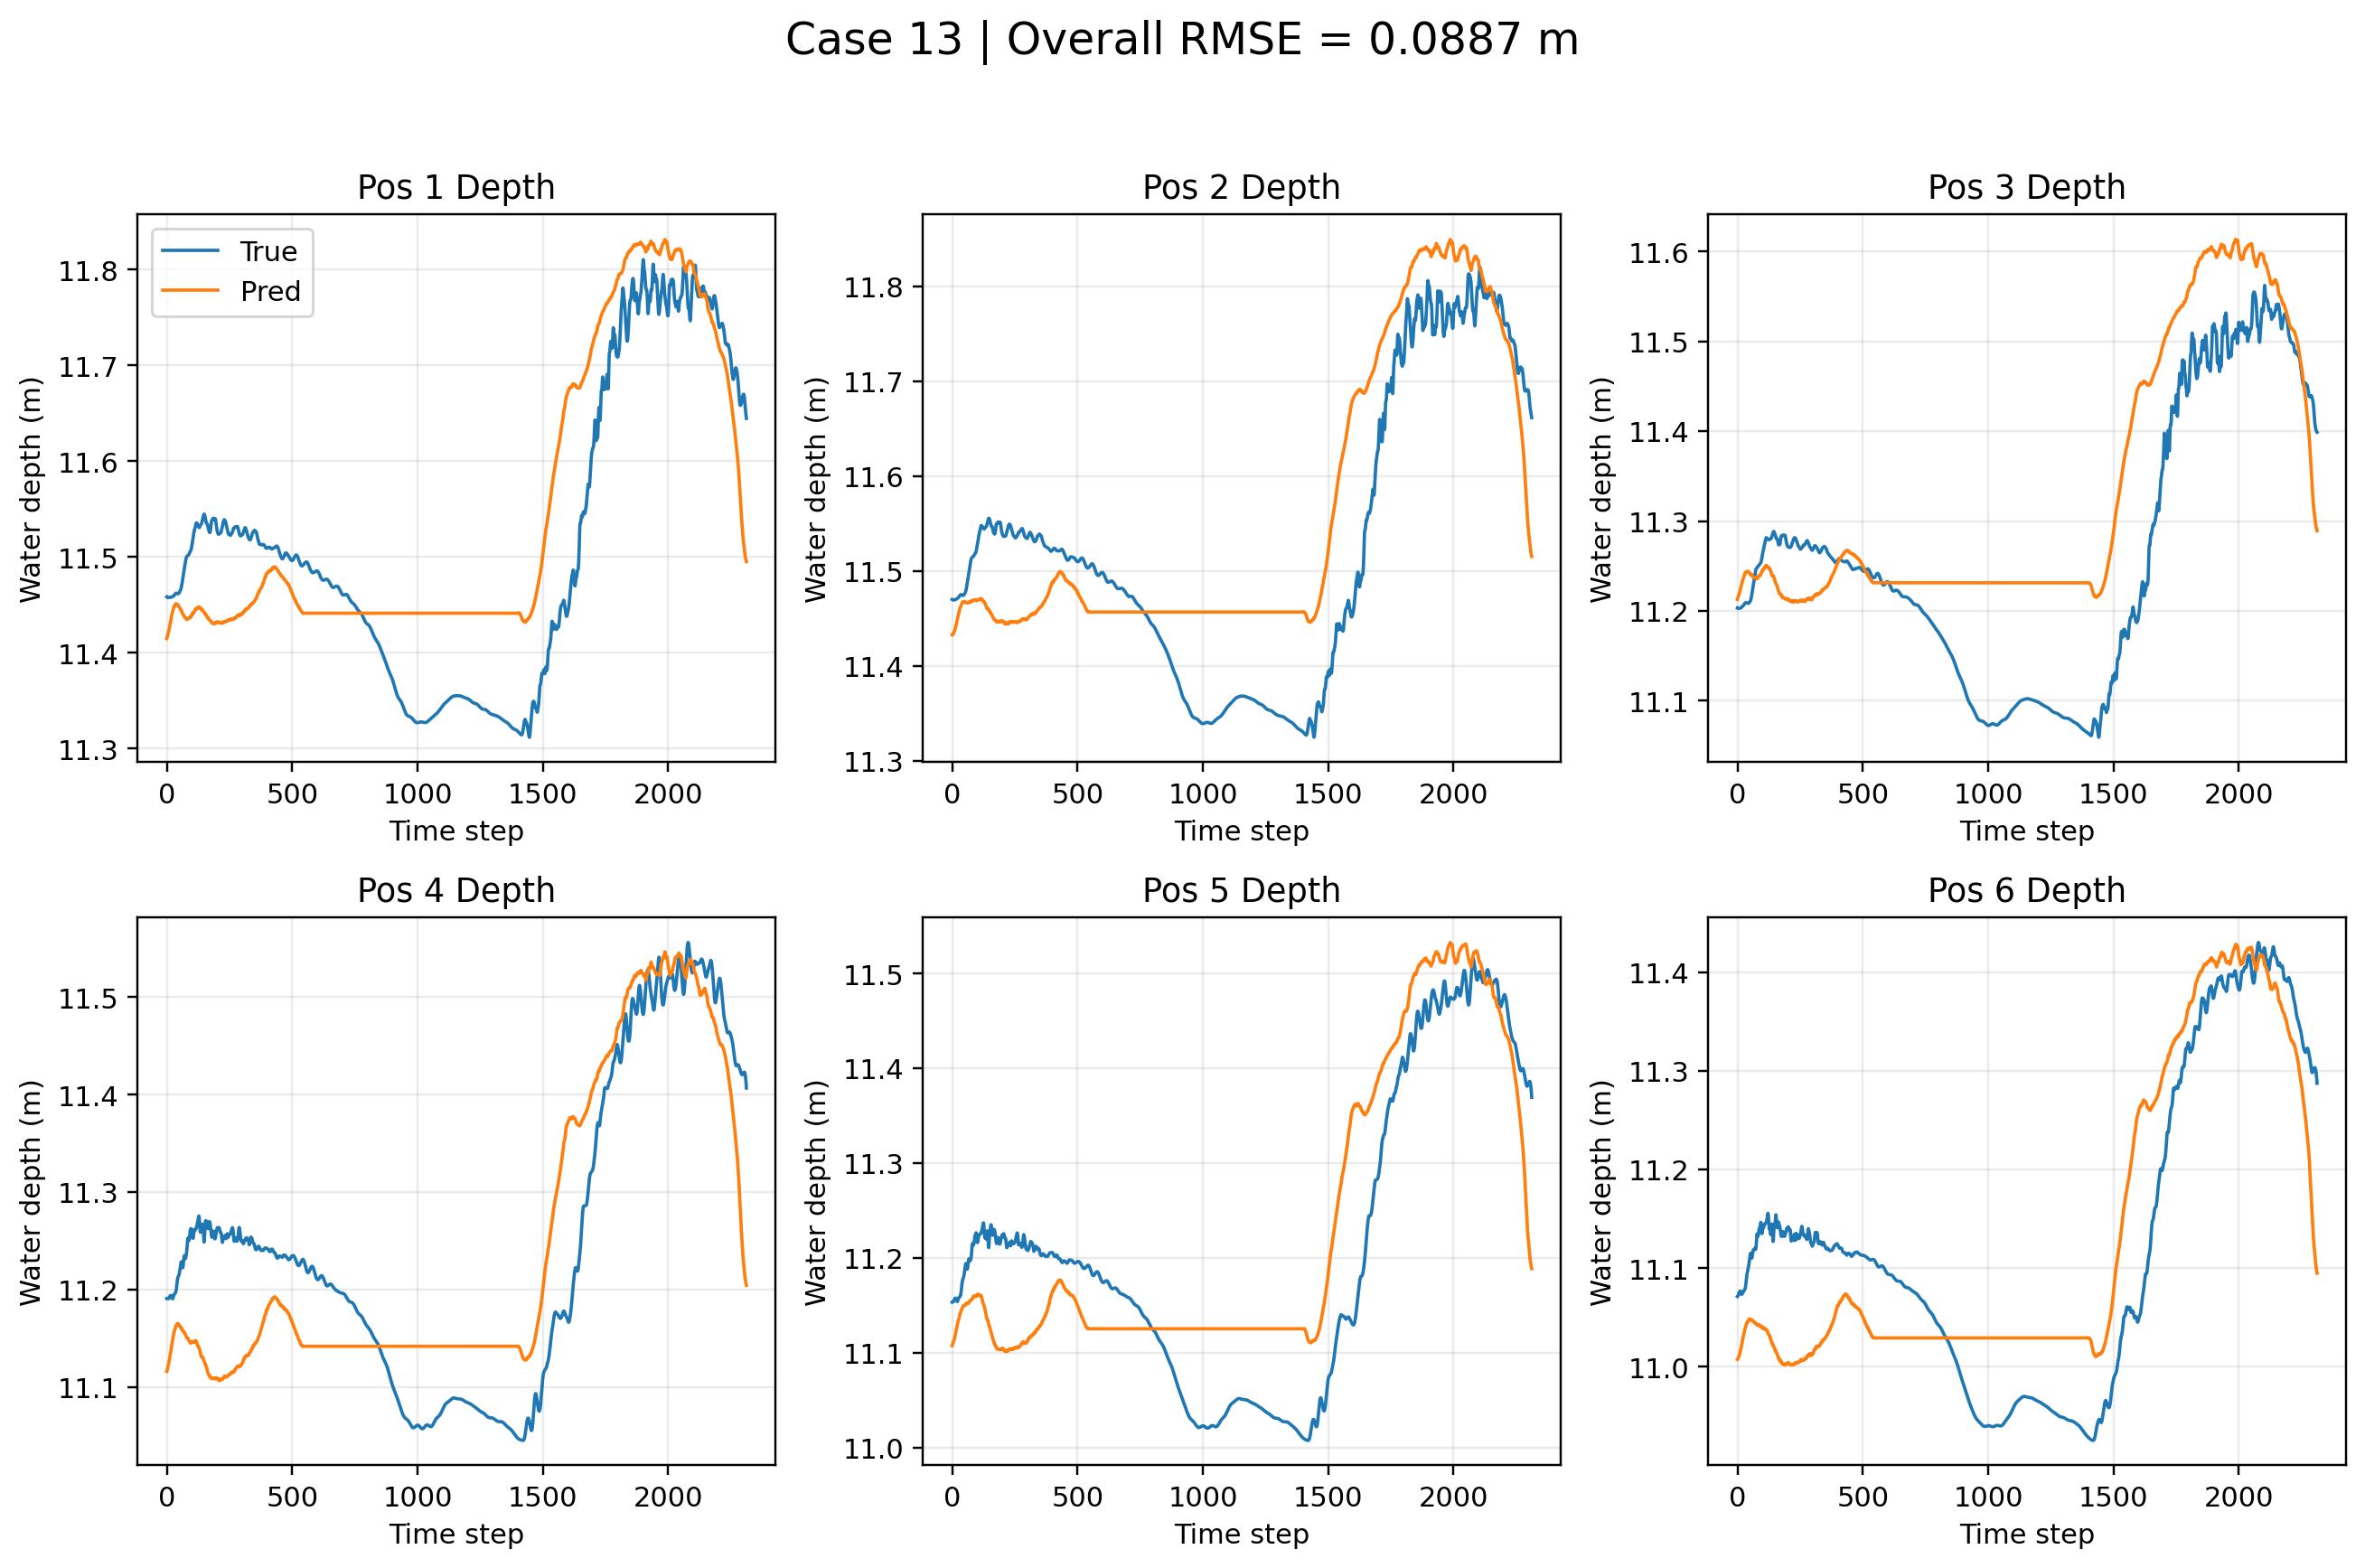

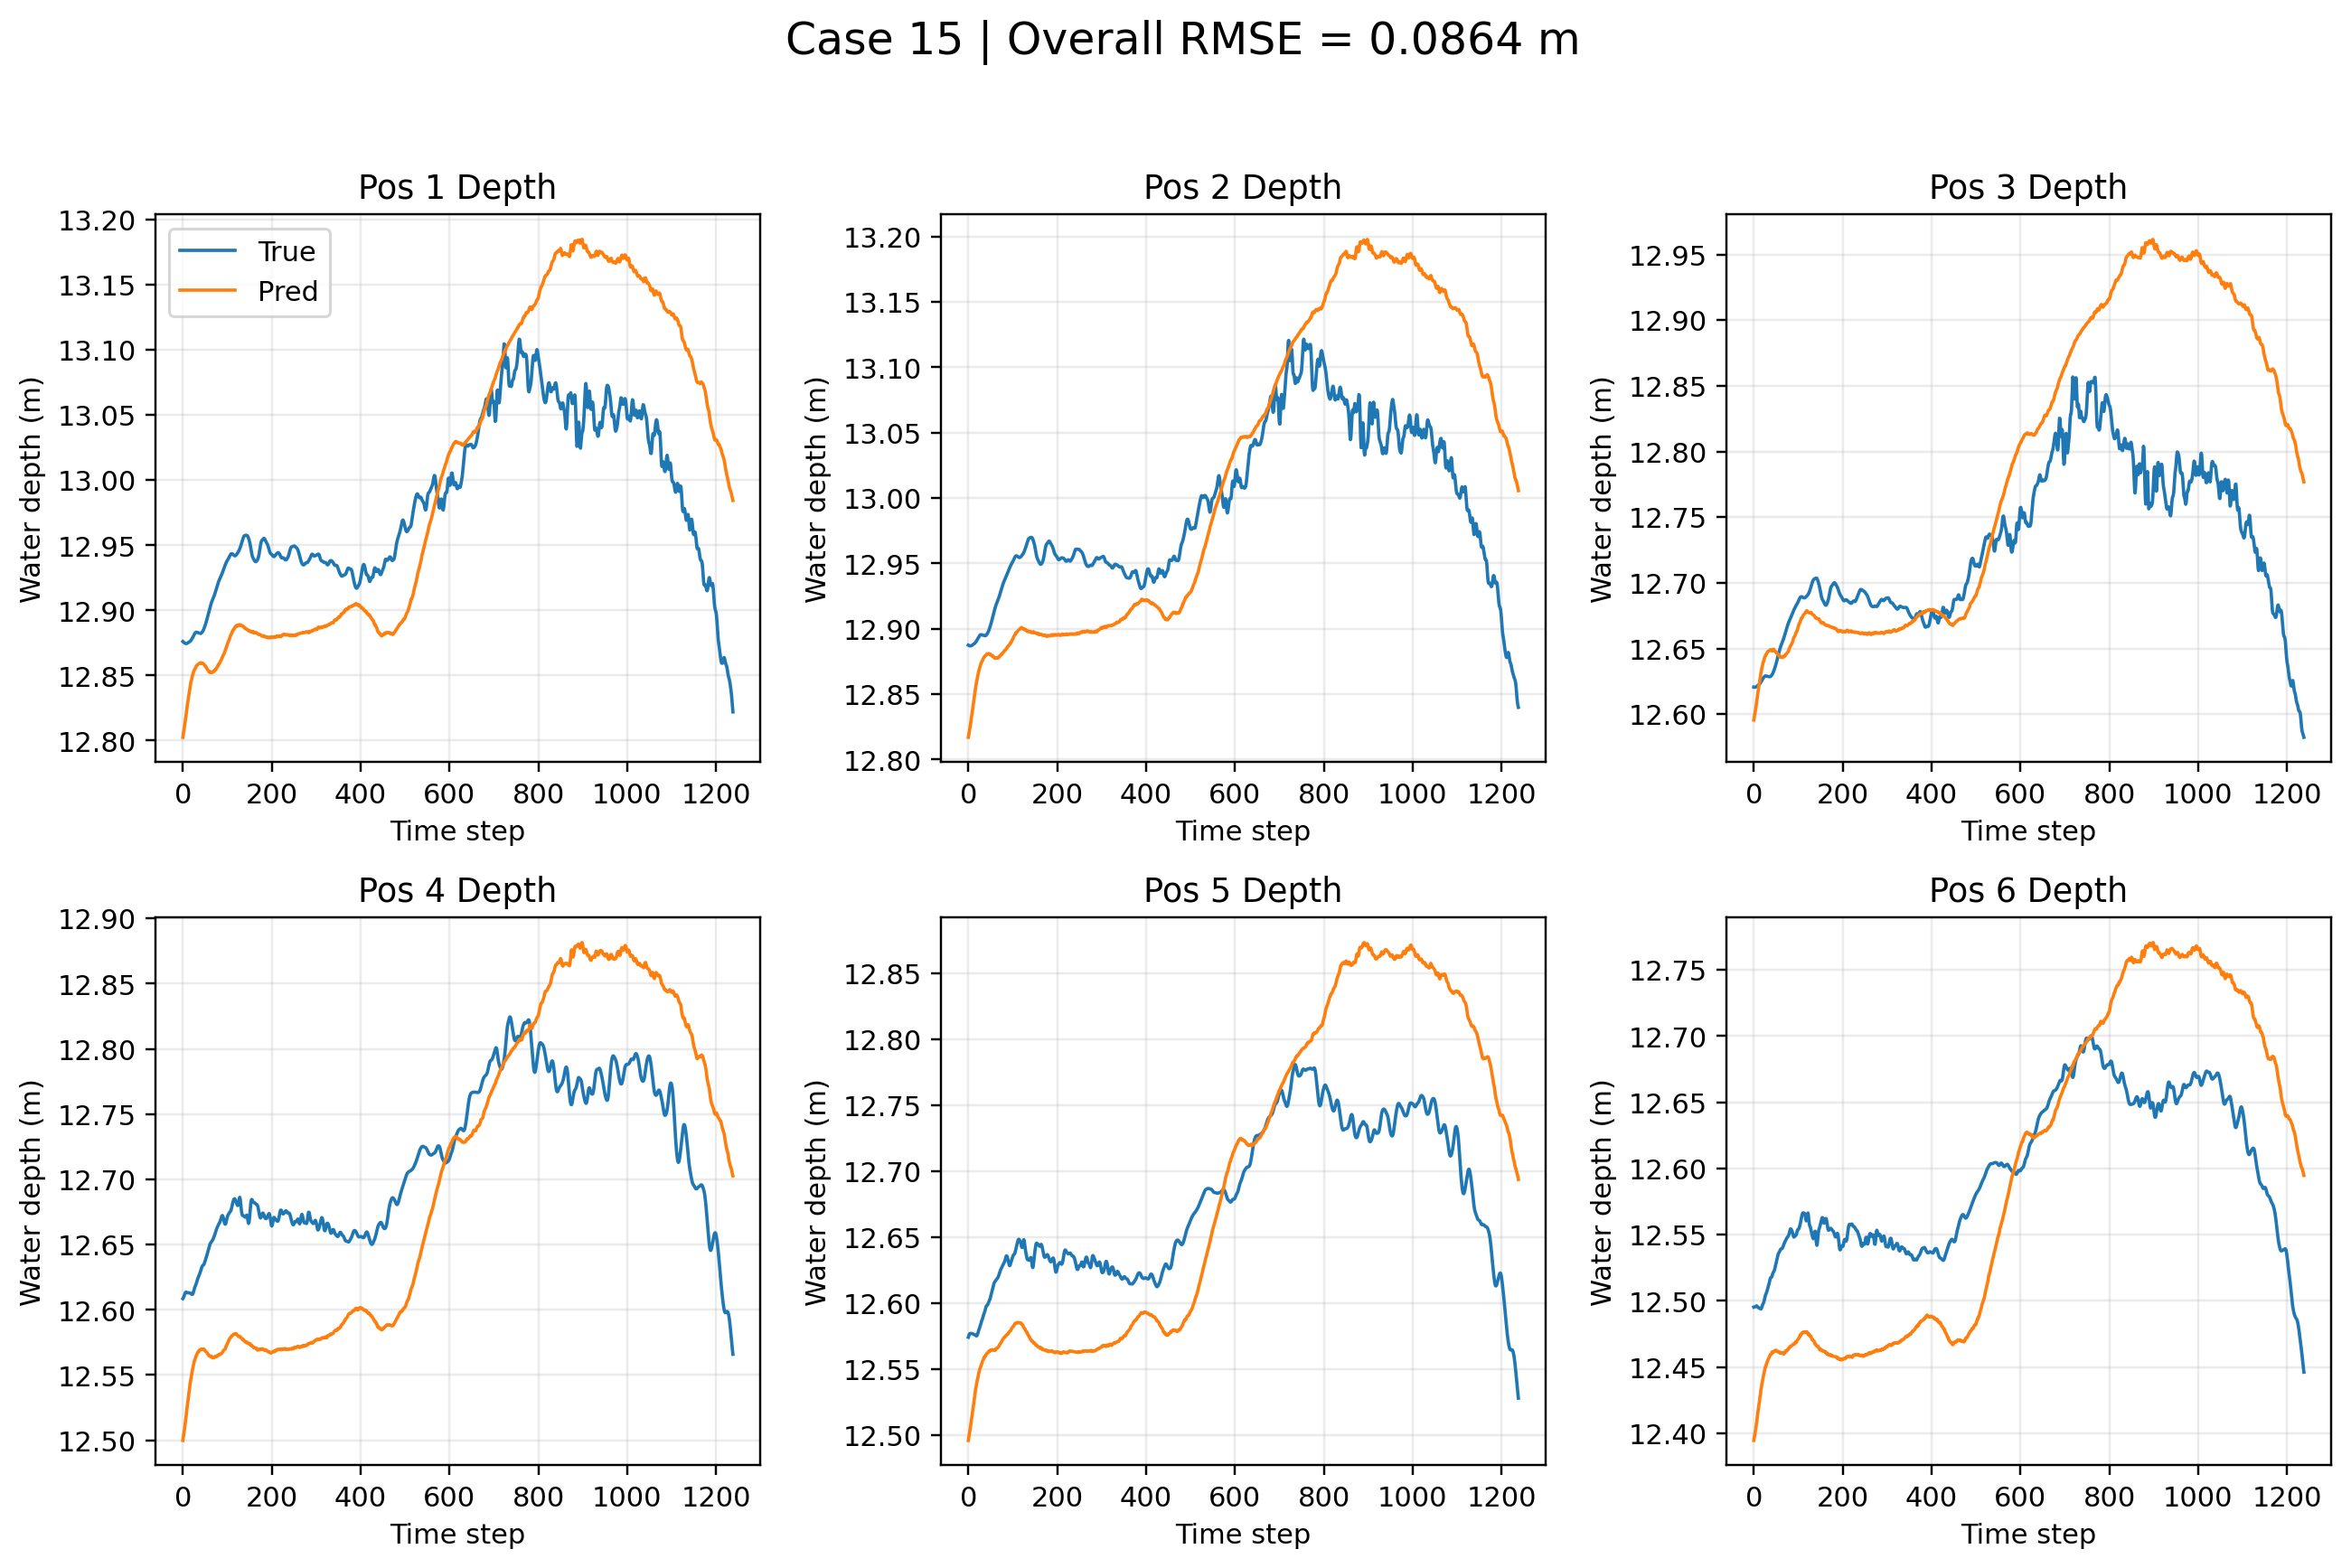

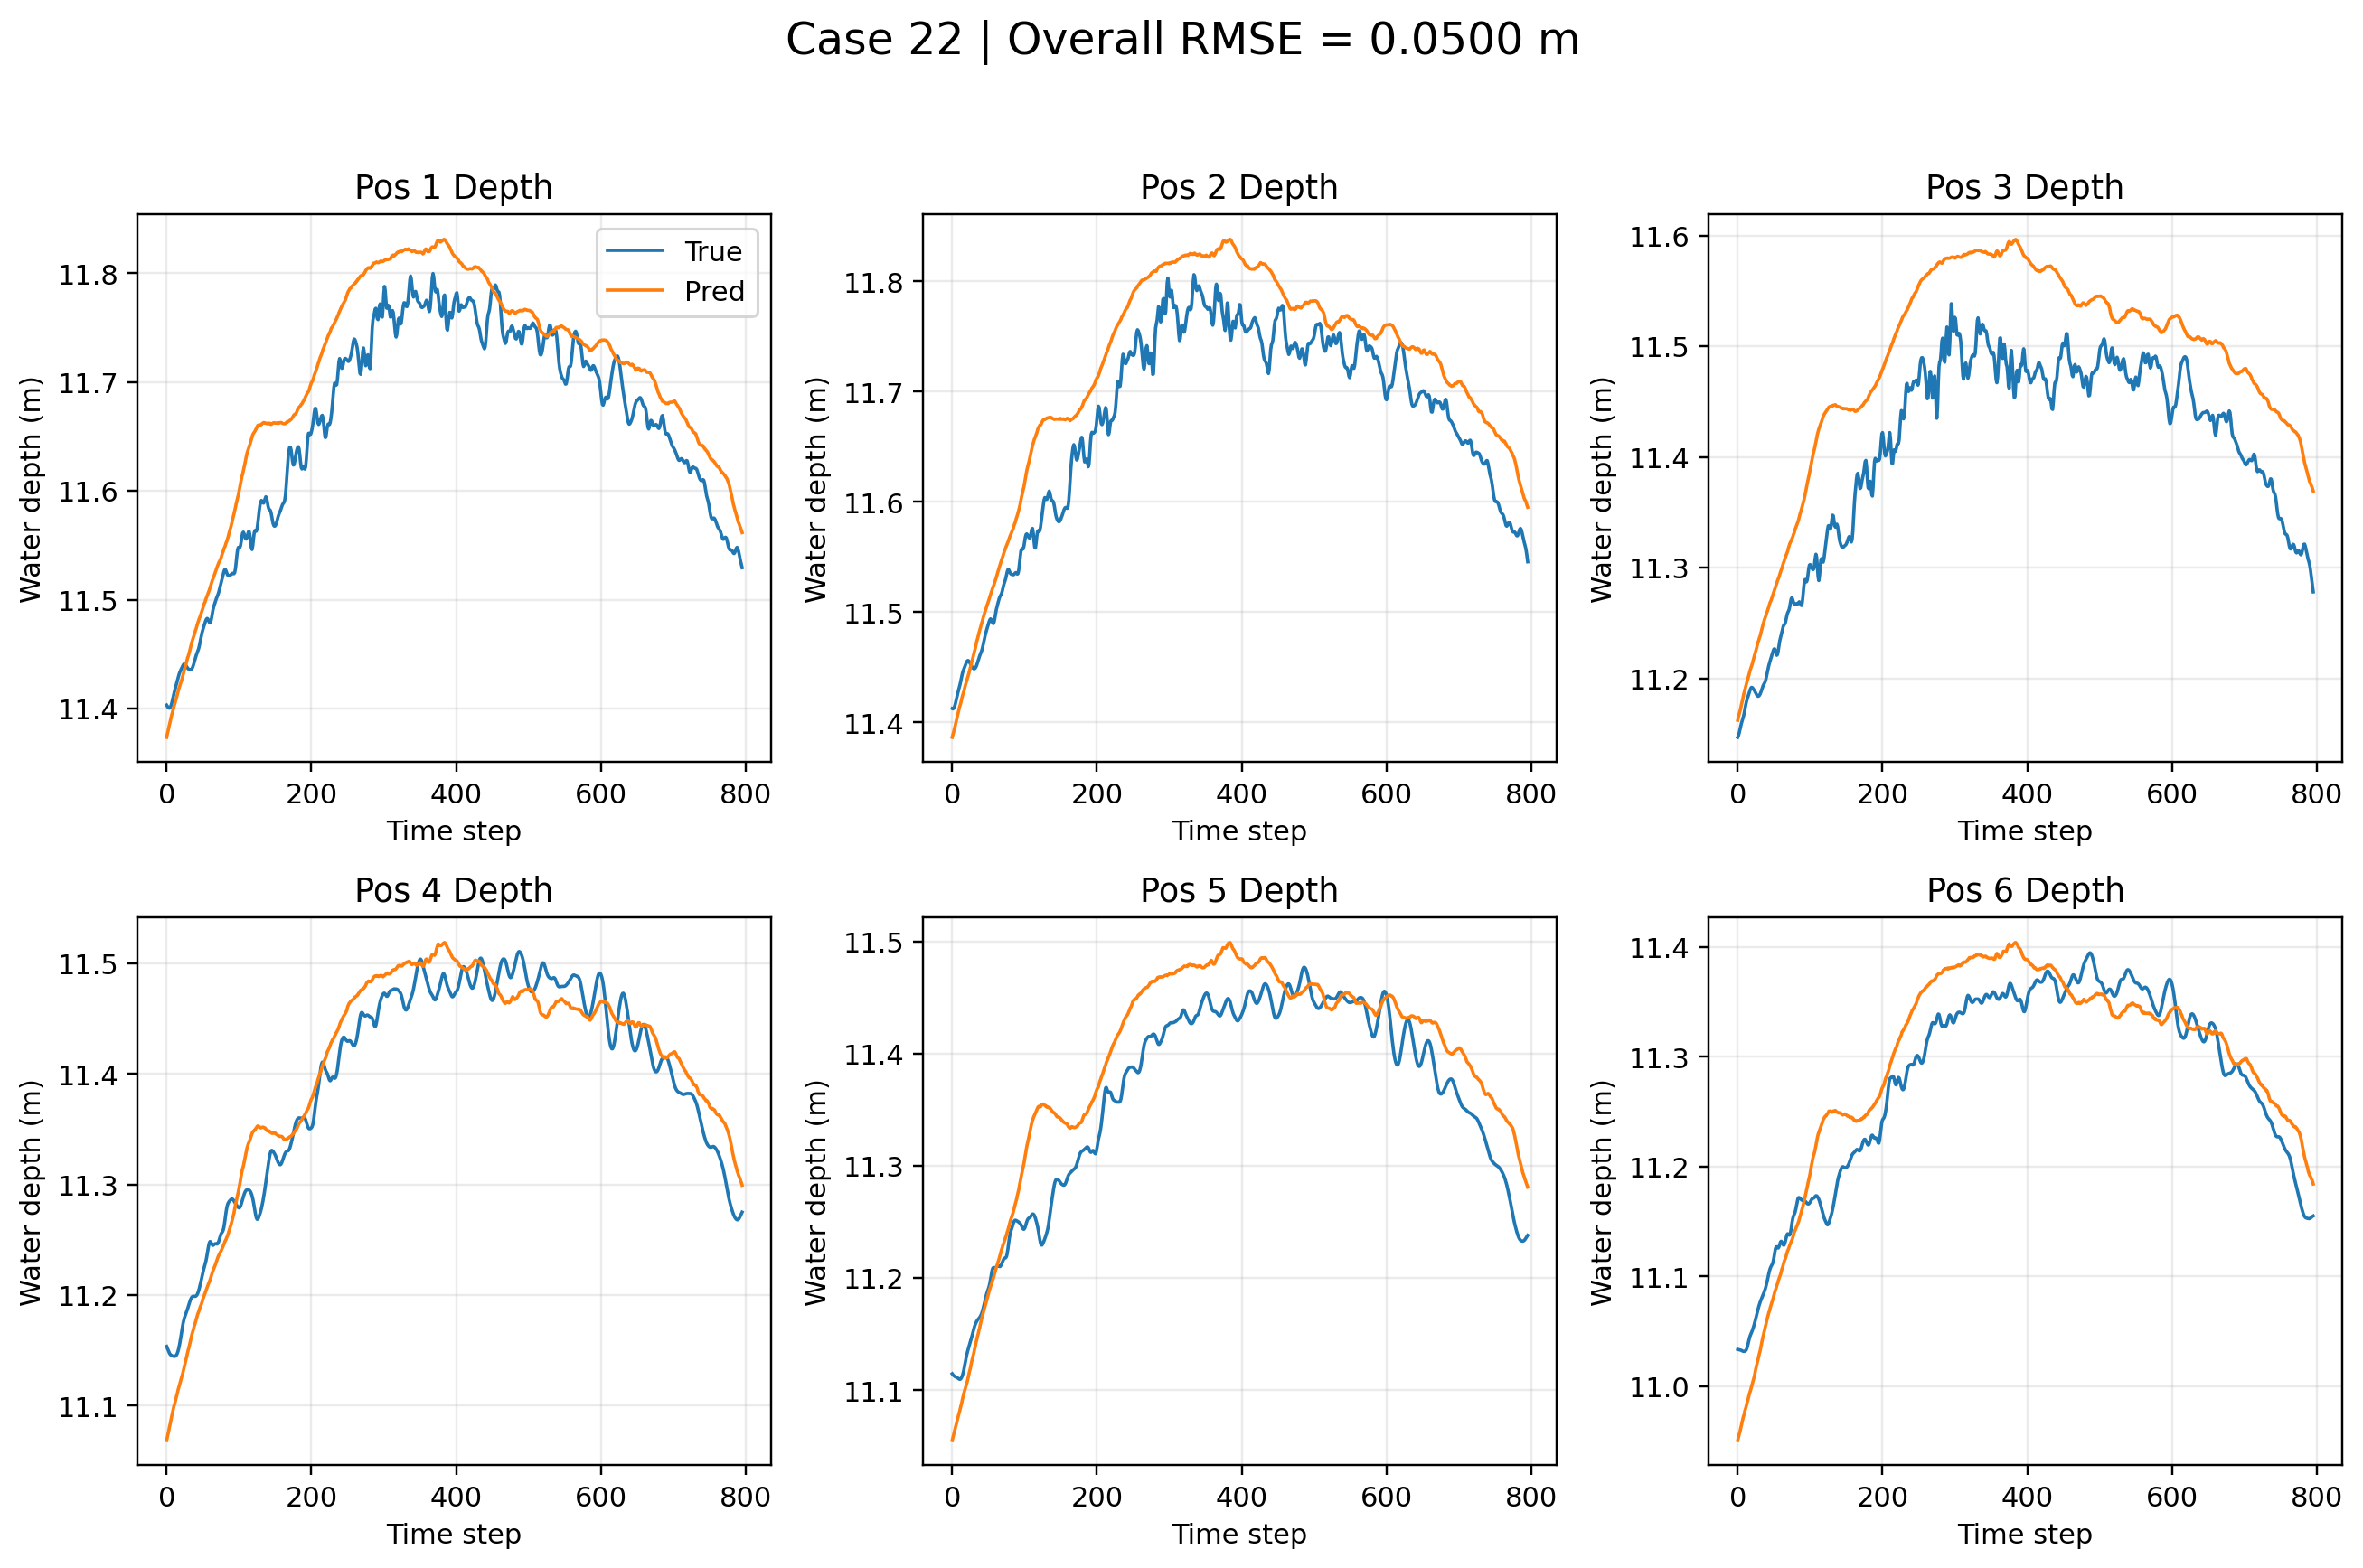

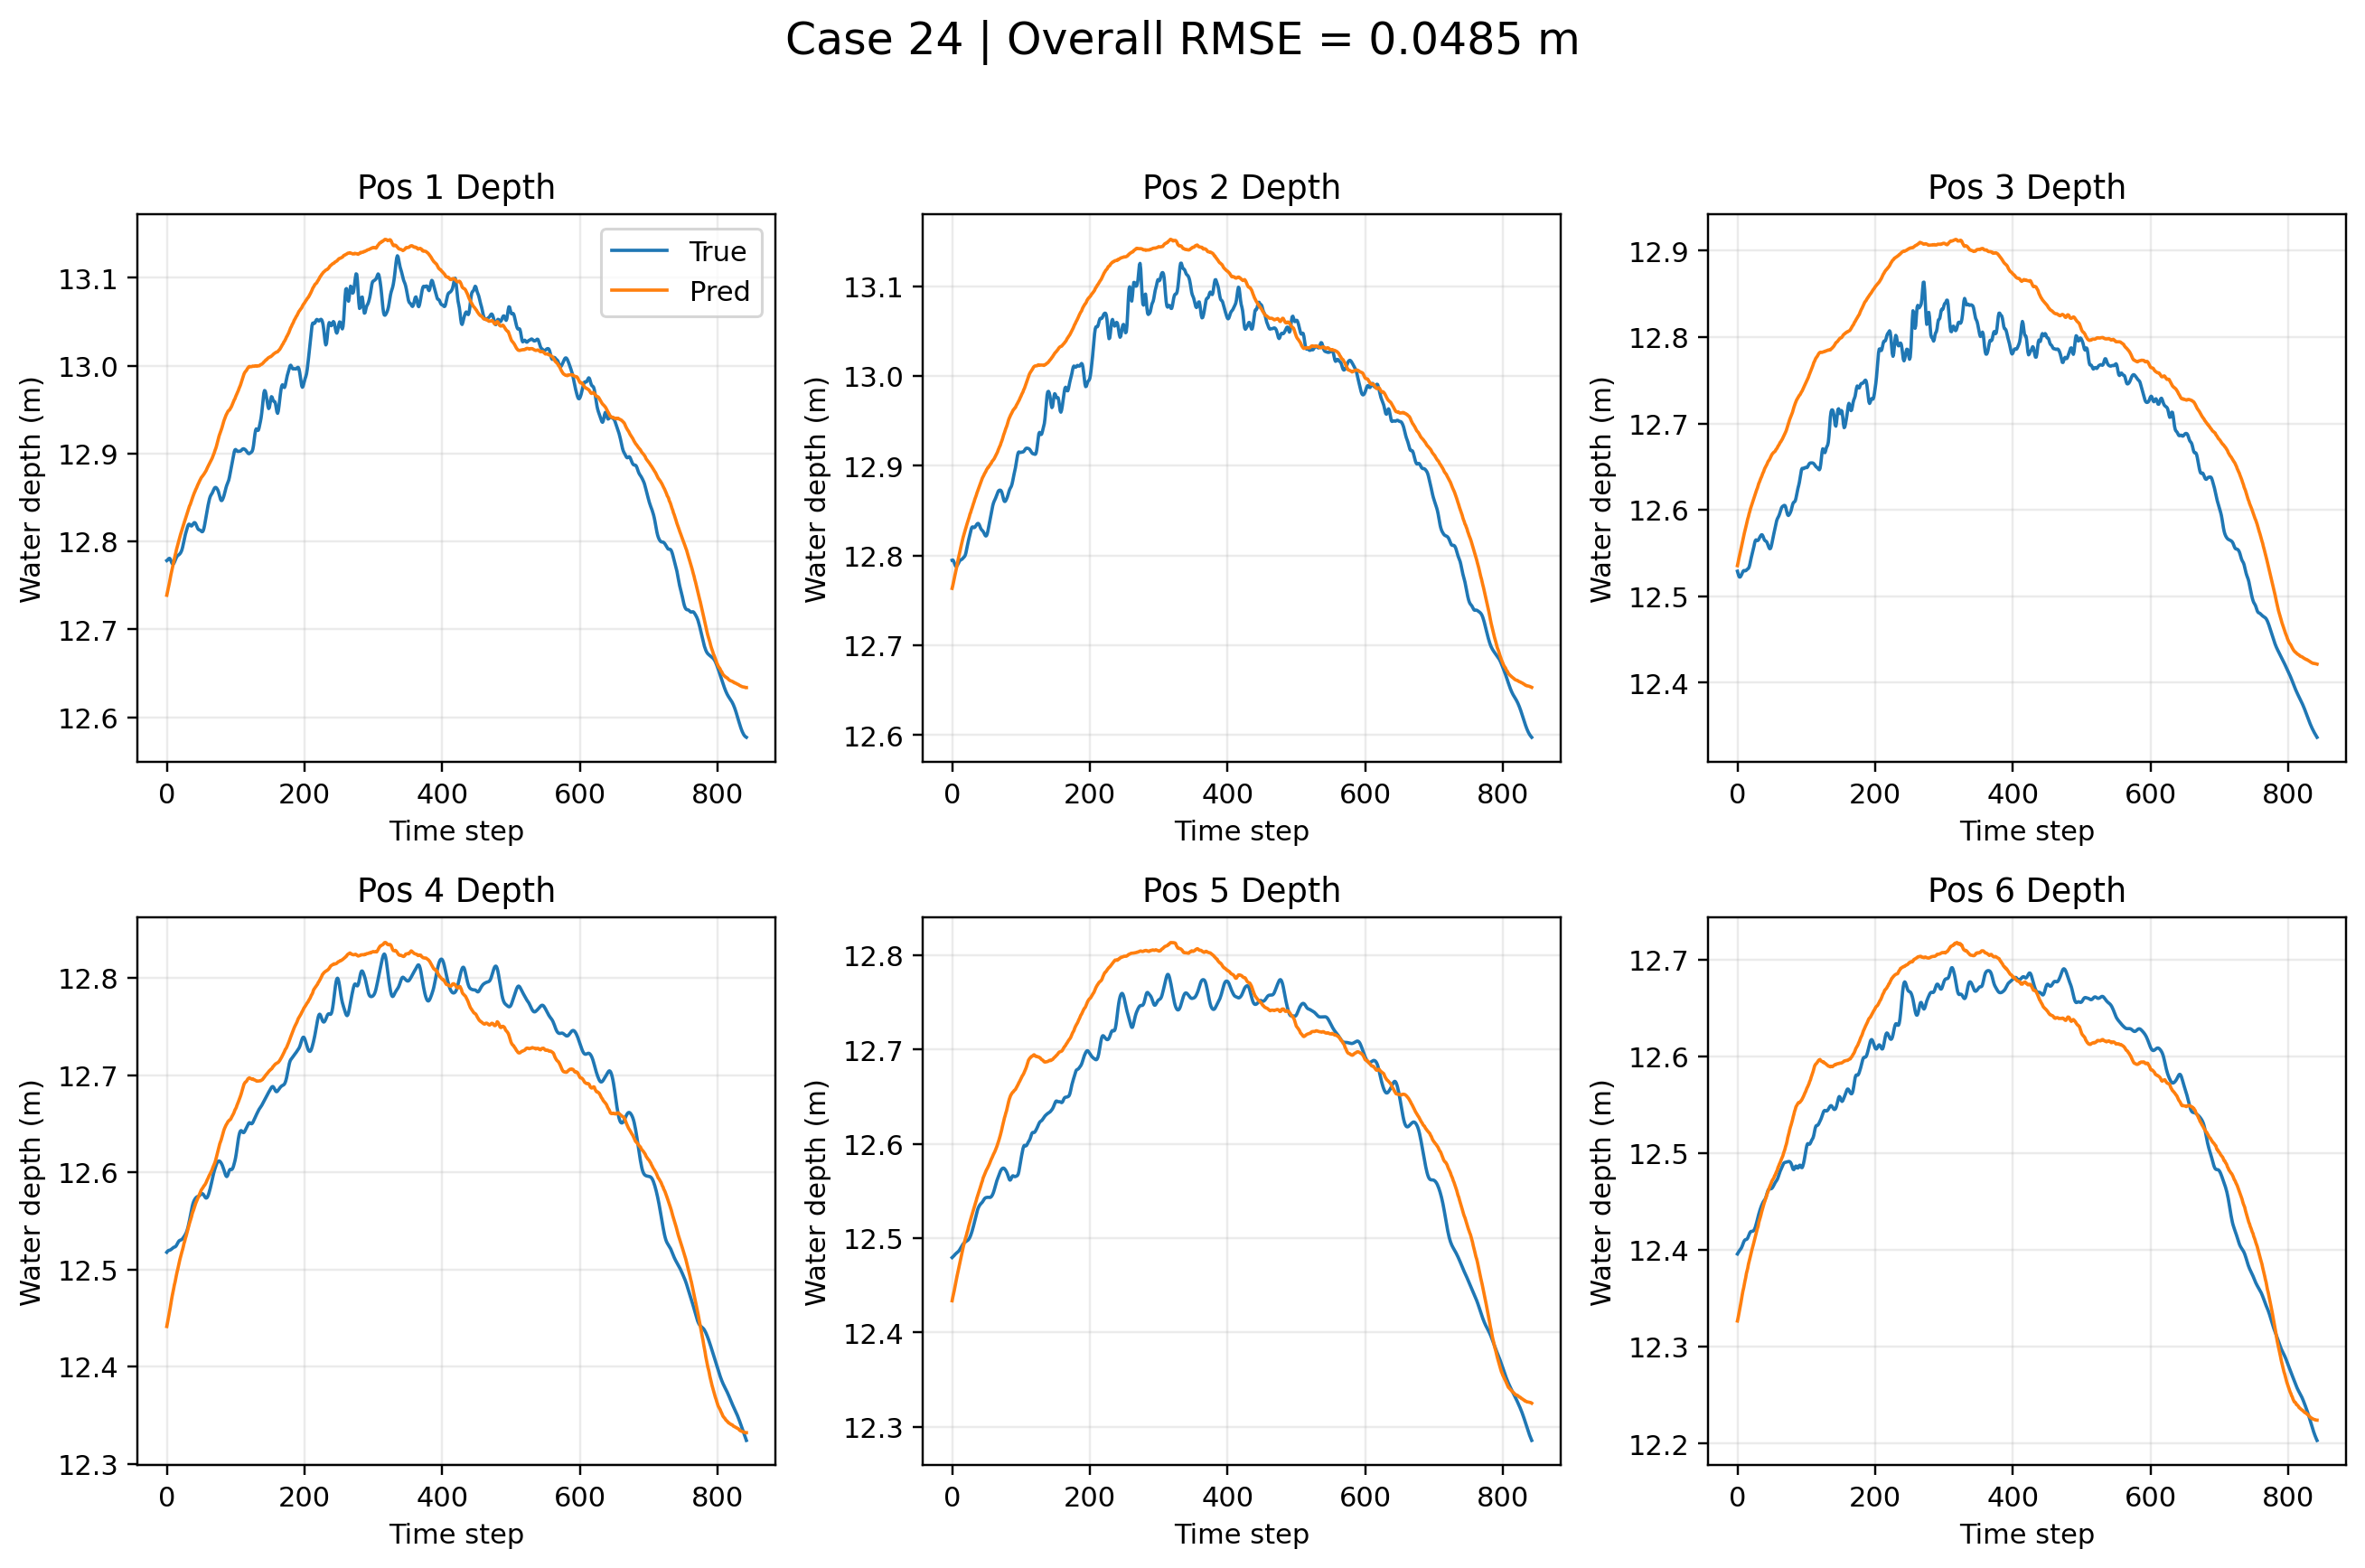

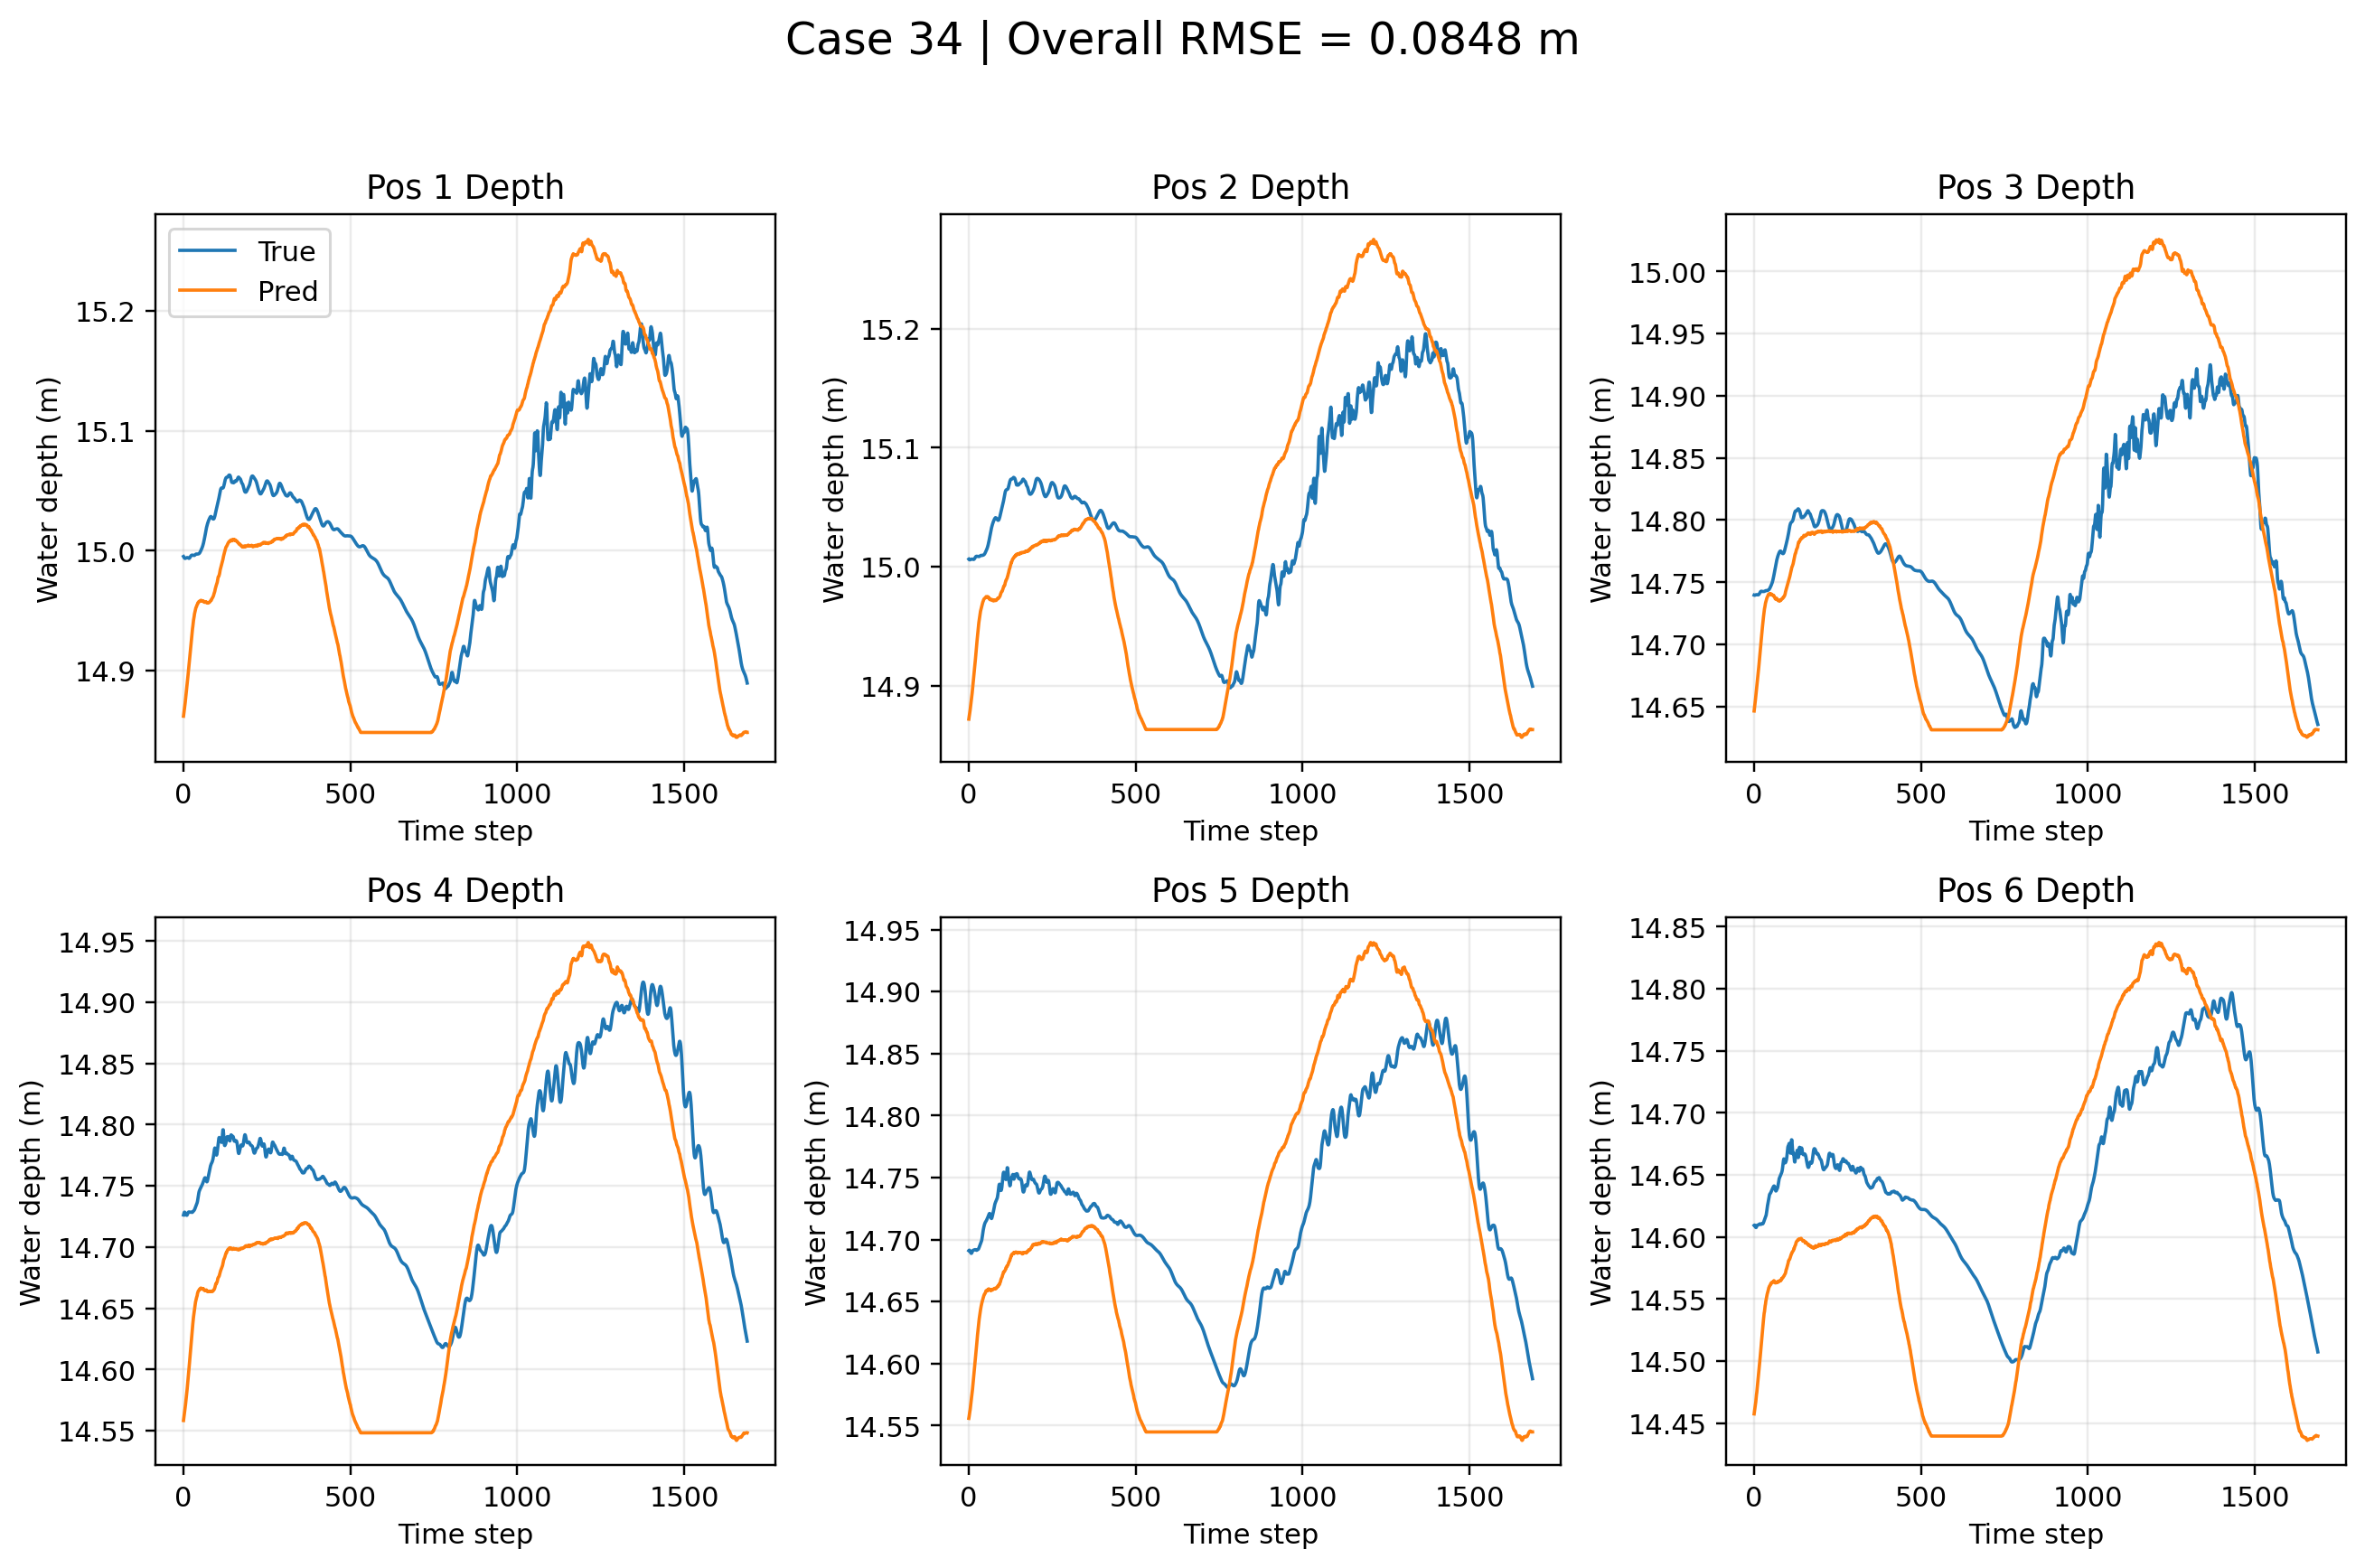

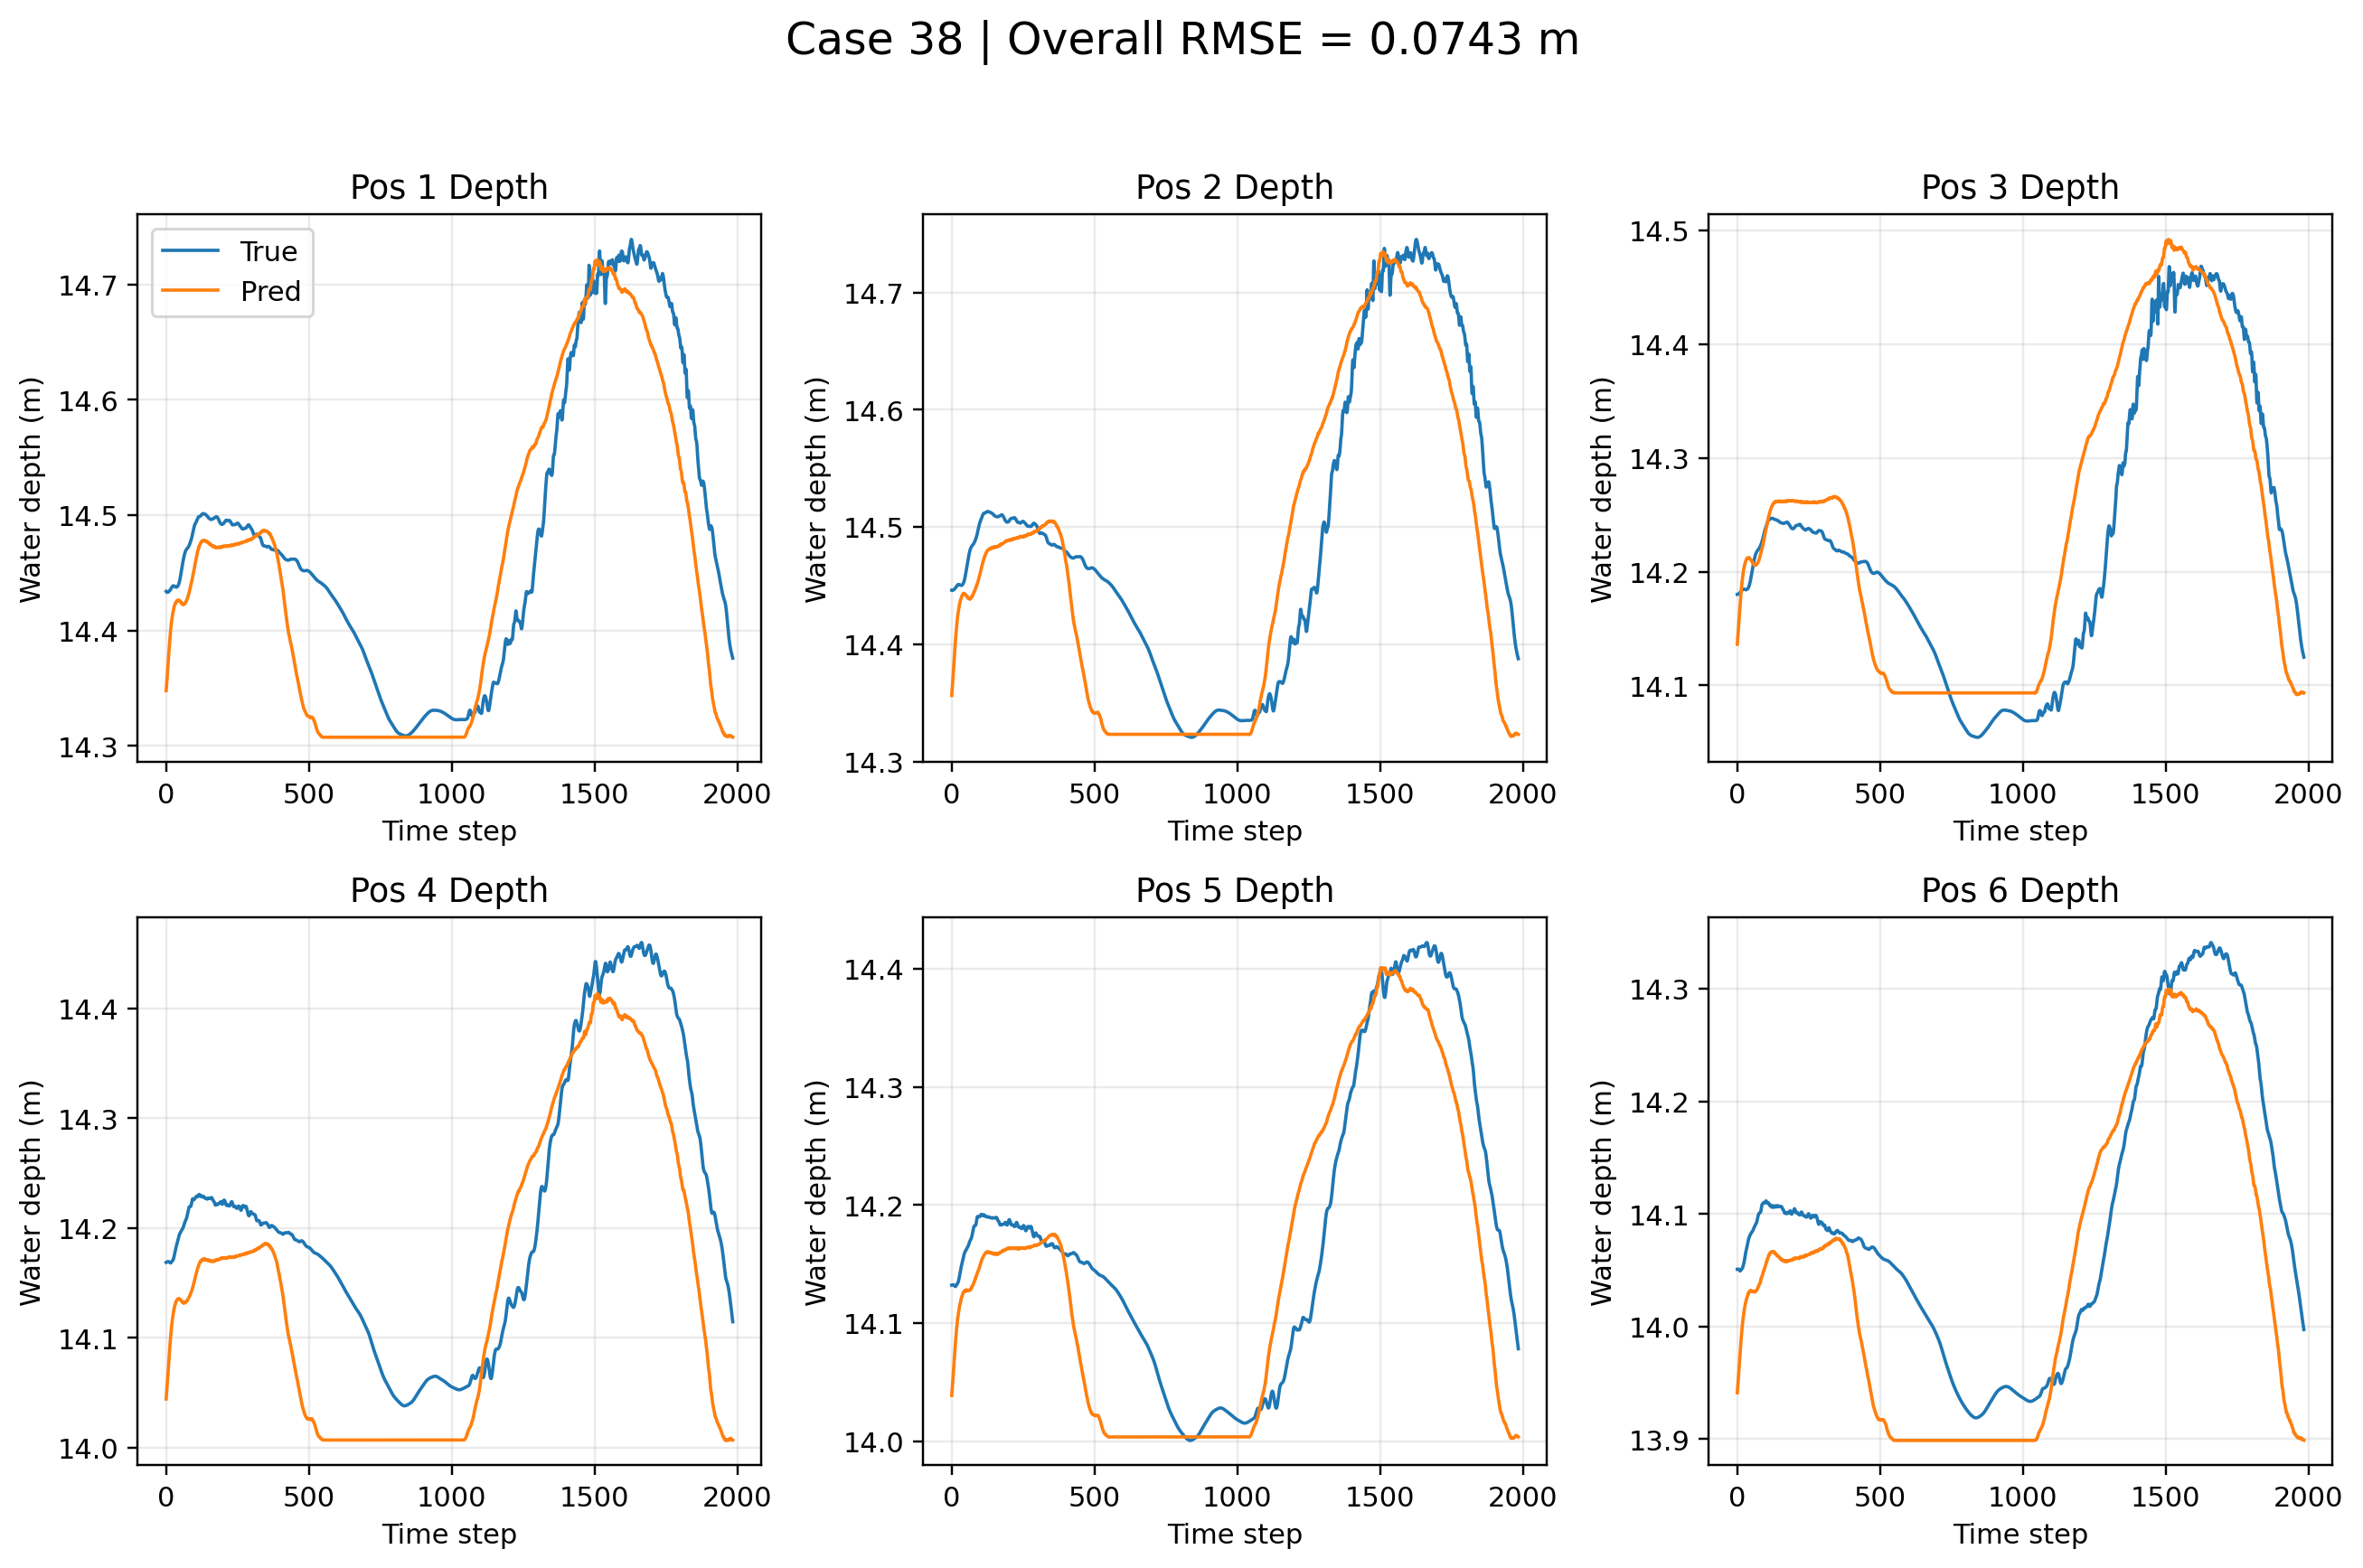

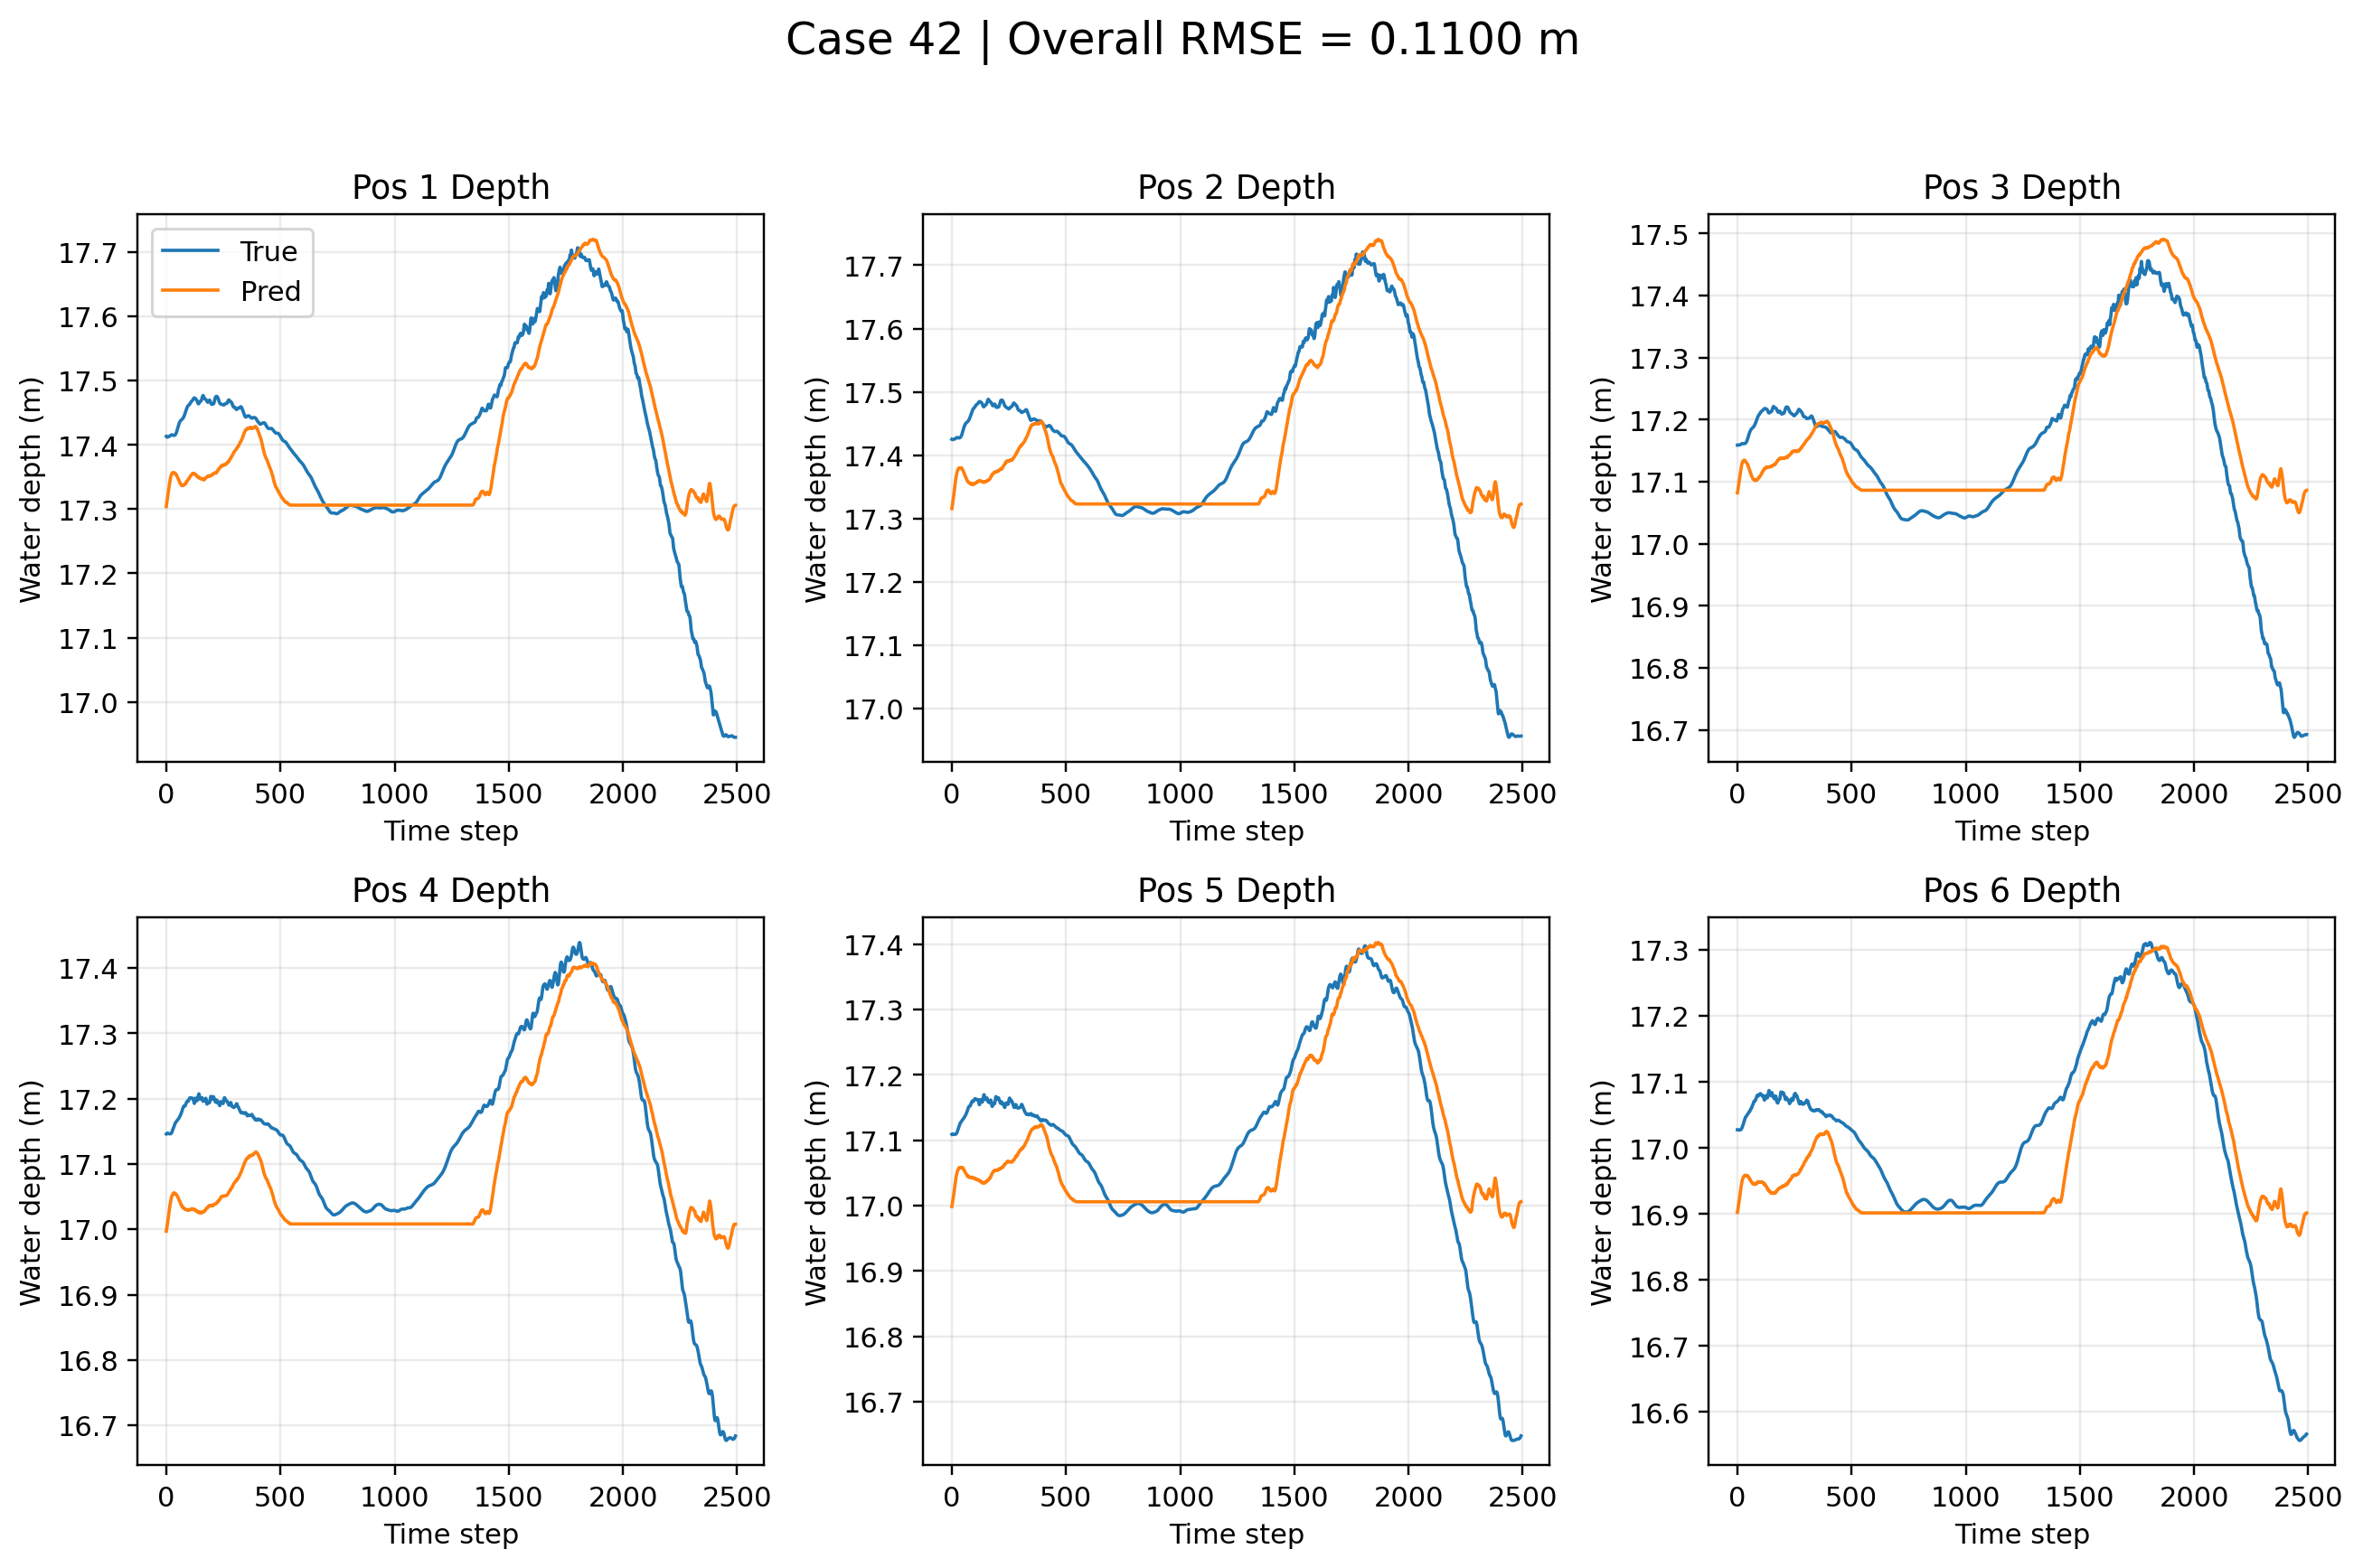

In [28]:
import matplotlib.pyplot as plt
import numpy as np

pos_names = [f"Pos {i}" for i in range(1, 7)]

for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, X_static_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, X_static_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)  
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)       

    rmse_case = float(np.sqrt(np.mean((y_pred_case_real - y_true_case_real) ** 2)))

    t = np.arange(y_true_case_real.shape[0])

    fig, axes = plt.subplots(
        2, 3,
        figsize=(12, 8),  
        dpi=220          
    )
    axes = axes.ravel()

    fig.suptitle(f"Case {cid} | Overall RMSE = {rmse_case:.4f} m", fontsize=16)

    for i in range(6):
        ax = axes[i]
        ax.plot(t, y_true_case_real[:, i], label="True", linewidth=1.2)
        ax.plot(t, y_pred_case_real[:, i], label="Pred", linewidth=1.2)

        ax.set_title(f"{pos_names[i]} Depth")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Water depth (m)")
        ax.grid(True, alpha=0.25)

        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()